In [51]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from numpy import array
from numpy import hstack

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [52]:
from sklearn.model_selection import RepeatedKFold

In [53]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
import datetime

In [55]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [56]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [57]:
data_dir = "../data/Air_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "IG_*_*.csv"))})

In [58]:
def get_train_and_test_index(scenario_index, random_state=None):
    if random_state == None:
        print('here')
        random_state = random.randrange(2652124)
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=random_state)

    train_index, test_index  = next(cv.split(scenario_index.index))
    
    return train_index, test_index

In [59]:
def load_data(scenario_index, selected_index, is_recurrent_test_data=False):
    """ Load data from files in scenario_index with indices matching ones in selected_index"""
    
    df_arr = []
    for f in scenario_index.loc[selected_index].filepath:
        Tw = float(f.split("/")[-1].split("_")[1])
        Ti = float(f.split("/")[-1].split("_")[2].replace(".csv", ""))

        f_df = pd.read_csv(f, skiprows=12)
        f_df["Tw"] = Tw
        f_df["Ti"] = Ti
        df_arr.append(f_df)
    
    return df_arr

In [60]:
train_index, test_index = get_train_and_test_index(scenario_index, random_state=5)

In [61]:
train_df = load_data(scenario_index, train_index)

In [62]:
test_df = load_data(scenario_index, test_index)

In [63]:
train_data = list()

for i, sample in enumerate(train_df):
    train_data.append(list())
    for j in range(sample.shape[0]):
        train_data[i].append([sample['Tw'][j],sample['Ti'][j],sample['Tc'][j]])

In [64]:
n_steps = 10
n_features = 3

In [65]:
test_data = list()
test_data_initial = list()

for i, sample in enumerate(test_df):
    test_data.append(list())
    test_data_initial.append(list())
    for j in range(sample.shape[0]):
        if j < n_steps:
            test_data_initial[i].append([sample['Tw'][j],sample['Ti'][j],sample['Tc'][j]])
        test_data[i].append([sample['Tw'][j],sample['Ti'][j],sample['Tc'][j]])

In [66]:
# split a univariate sequence
def split_sequence(sequences, n_steps):
    X, y = list(), list()
    for sequence in sequences:
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix][2]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

In [67]:
# split into samples
X_train, y_train = split_sequence(train_data, n_steps)
X_test, y_test = split_sequence(test_data, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [68]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(n_steps, n_features)))
#model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.fit(x=X_train, 
          y=y_train,
          batch_size=10,
          epochs=3, 
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback])

Train on 235872 samples, validate on 58968 samples
Epoch 1/3
    20/235872 [..............................] - ETA: 8:17:35 - loss: 178302.1797 

2022-06-22 01:00:40.171203: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


235872/235872 [==============================] - 295s 1ms/sample - loss: 349.0663 - val_loss: 1.1338
Epoch 2/3
235872/235872 [==============================] - 294s 1ms/sample - loss: 1.1165 - val_loss: 0.0815
Epoch 3/3
235872/235872 [==============================] - 297s 1ms/sample - loss: 0.5105 - val_loss: 1.9596


In [71]:
model.fit(x=X_train, 
          y=y_train,
          batch_size=2116 - n_steps,
          epochs=1, 
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback])

Train on 235872 samples, validate on 58968 samples
235872/235872 [==============================] - 13s 54us/sample - loss: 0.1299 - val_loss: 0.0152


In [72]:
# split a univariate sequence
def split_initial_sequence(sequences, n_steps):
    X = list()
    for sequence in sequences:
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence):
                break
            # gather input and output parts of the pattern
            seq_x = sequence[i:end_ix]
            X.append(seq_x)
    return array(X)

In [73]:
X_test_initial = split_initial_sequence(test_data_initial, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_test_initial = X_test_initial.reshape((X_test_initial.shape[0], X_test_initial.shape[1], n_features))

In [74]:
yhat = list()
for j, x_input in enumerate(X_test_initial):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat_sample = list()
    Tw = x_input[0][0][0]
    Ti = x_input[0][0][1]
    print('Generating Predictions for Sample:',j,'Tw:',Tw,'Ti:',Ti)
    for i in range(n_steps):
        yhat_sample.append(x_input[0][i][2])
    for i in range(2116 - n_steps):
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat_timestep = model.predict(x_input, verbose=0)
        x_input = np.delete(x_input, [0,1,2])
        x_input = np.append(x_input, [Tw, Ti, yhat_timestep[0][0]])
        yhat_sample.append(yhat_timestep[0][0])
    yhat.append(yhat_sample)

Generating Predictions for Sample: 0 Tw: 600.0 Ti: 370.0
Generating Predictions for Sample: 1 Tw: 590.0 Ti: 300.0
Generating Predictions for Sample: 2 Tw: 330.0 Ti: 300.0
Generating Predictions for Sample: 3 Tw: 550.0 Ti: 410.0
Generating Predictions for Sample: 4 Tw: 580.0 Ti: 500.0
Generating Predictions for Sample: 5 Tw: 550.0 Ti: 500.0
Generating Predictions for Sample: 6 Tw: 350.0 Ti: 300.0
Generating Predictions for Sample: 7 Tw: 500.0 Ti: 480.0
Generating Predictions for Sample: 8 Tw: 490.0 Ti: 300.0
Generating Predictions for Sample: 9 Tw: 440.0 Ti: 400.0
Generating Predictions for Sample: 10 Tw: 600.0 Ti: 460.0
Generating Predictions for Sample: 11 Tw: 550.0 Ti: 310.0
Generating Predictions for Sample: 12 Tw: 500.0 Ti: 440.0
Generating Predictions for Sample: 13 Tw: 580.0 Ti: 400.0
Generating Predictions for Sample: 14 Tw: 450.0 Ti: 360.0
Generating Predictions for Sample: 15 Tw: 500.0 Ti: 320.0
Generating Predictions for Sample: 16 Tw: 550.0 Ti: 520.0
Generating Predictions f

In [84]:
y = list()
for i, sample in enumerate(test_data):
    y.append(list())
    for timestep in sample:
        y[i].append(timestep[2])

In [85]:
import matplotlib.pyplot as plt

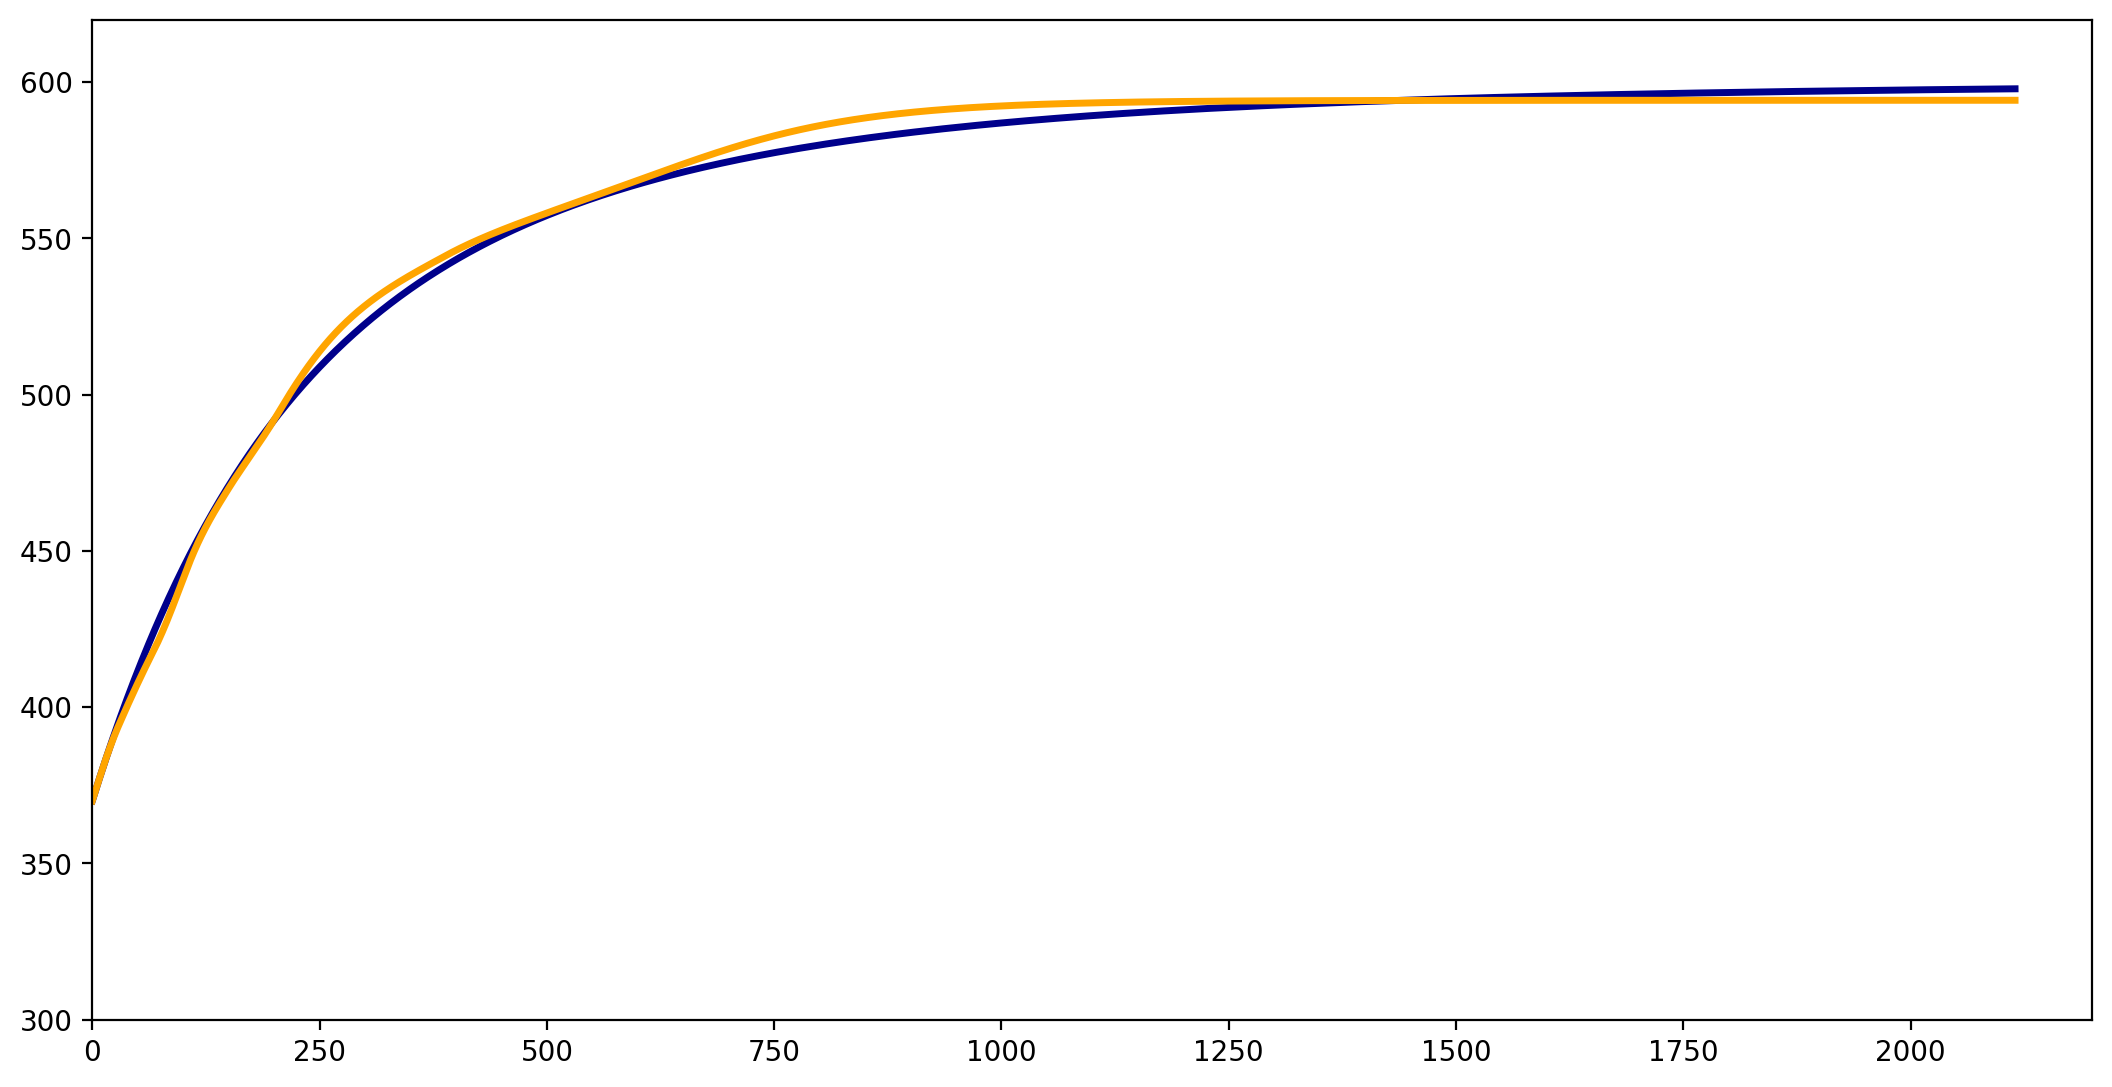

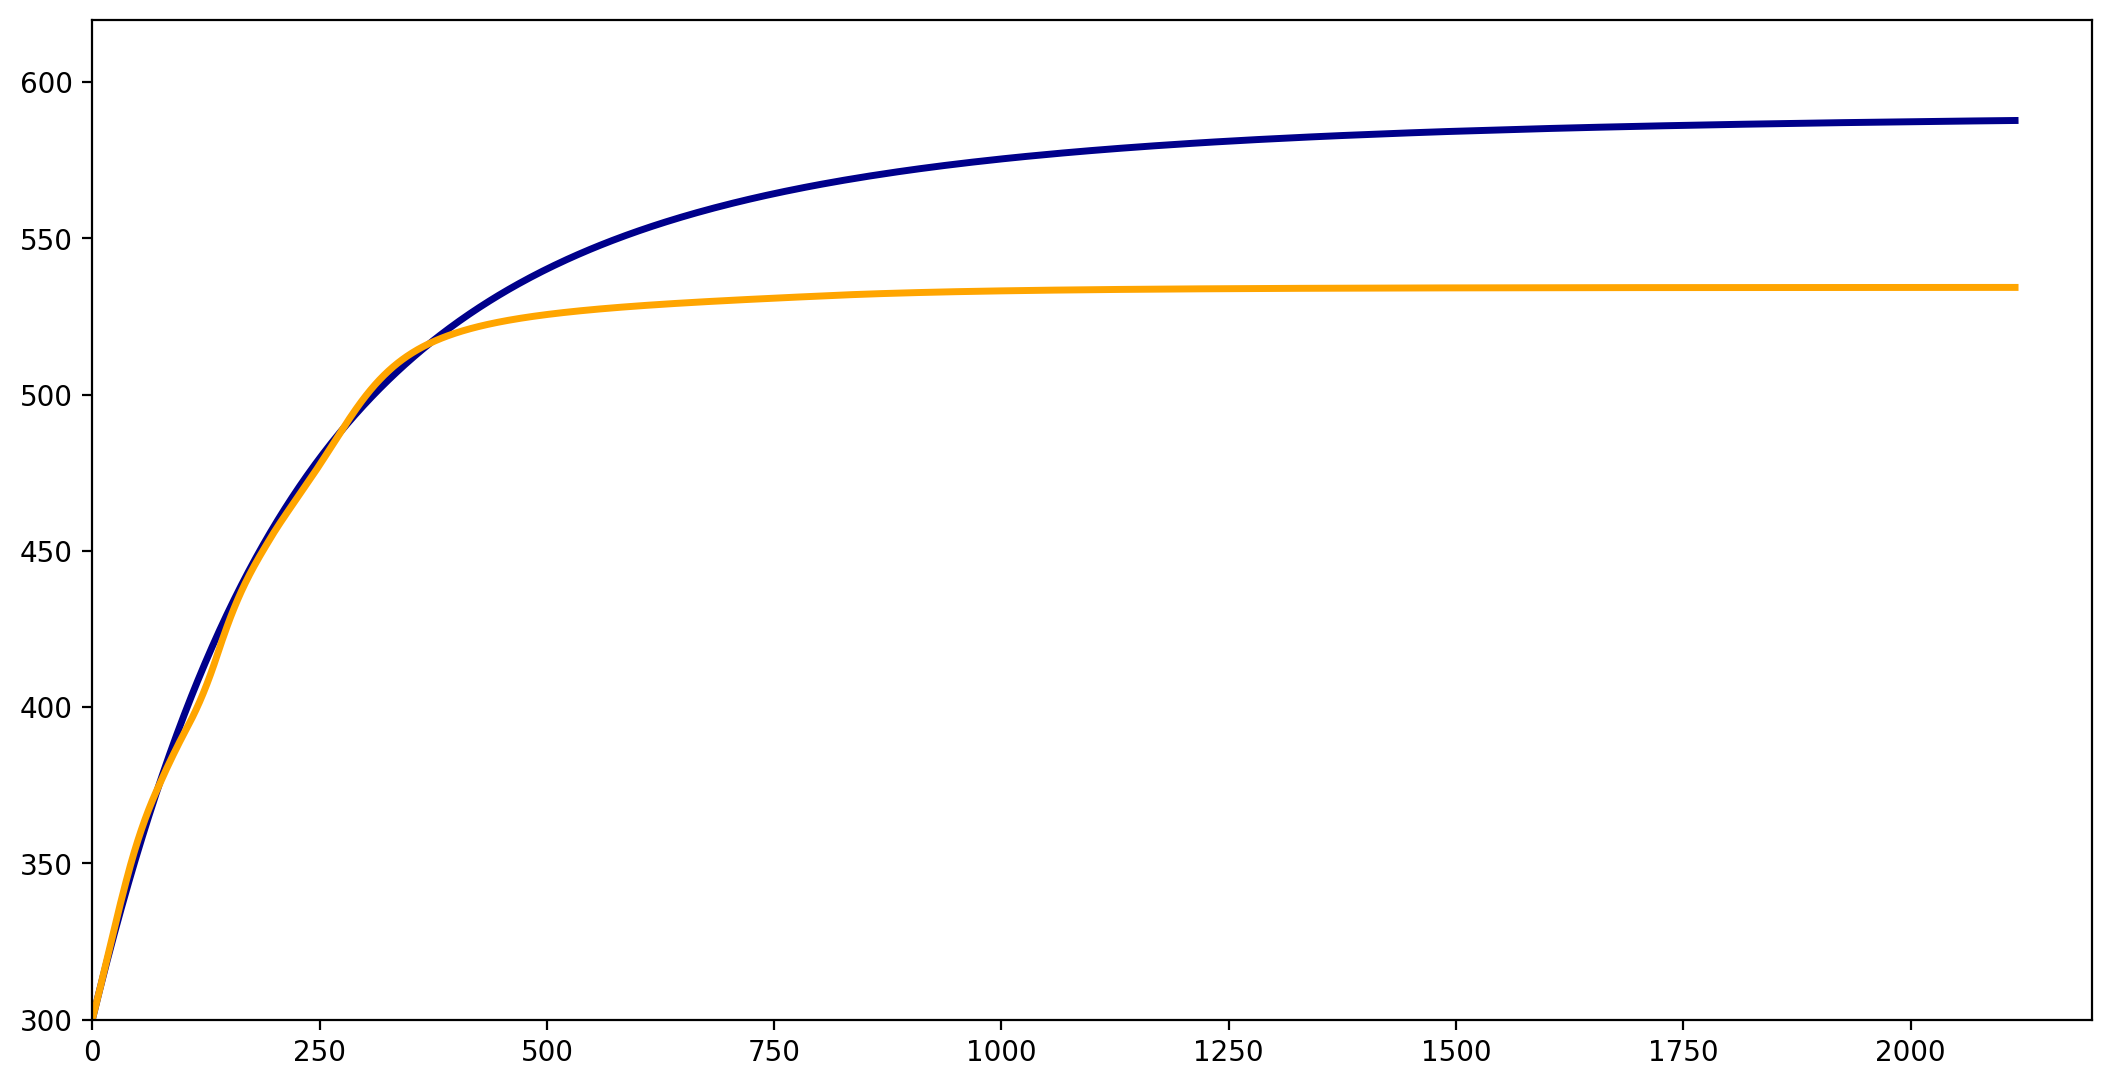

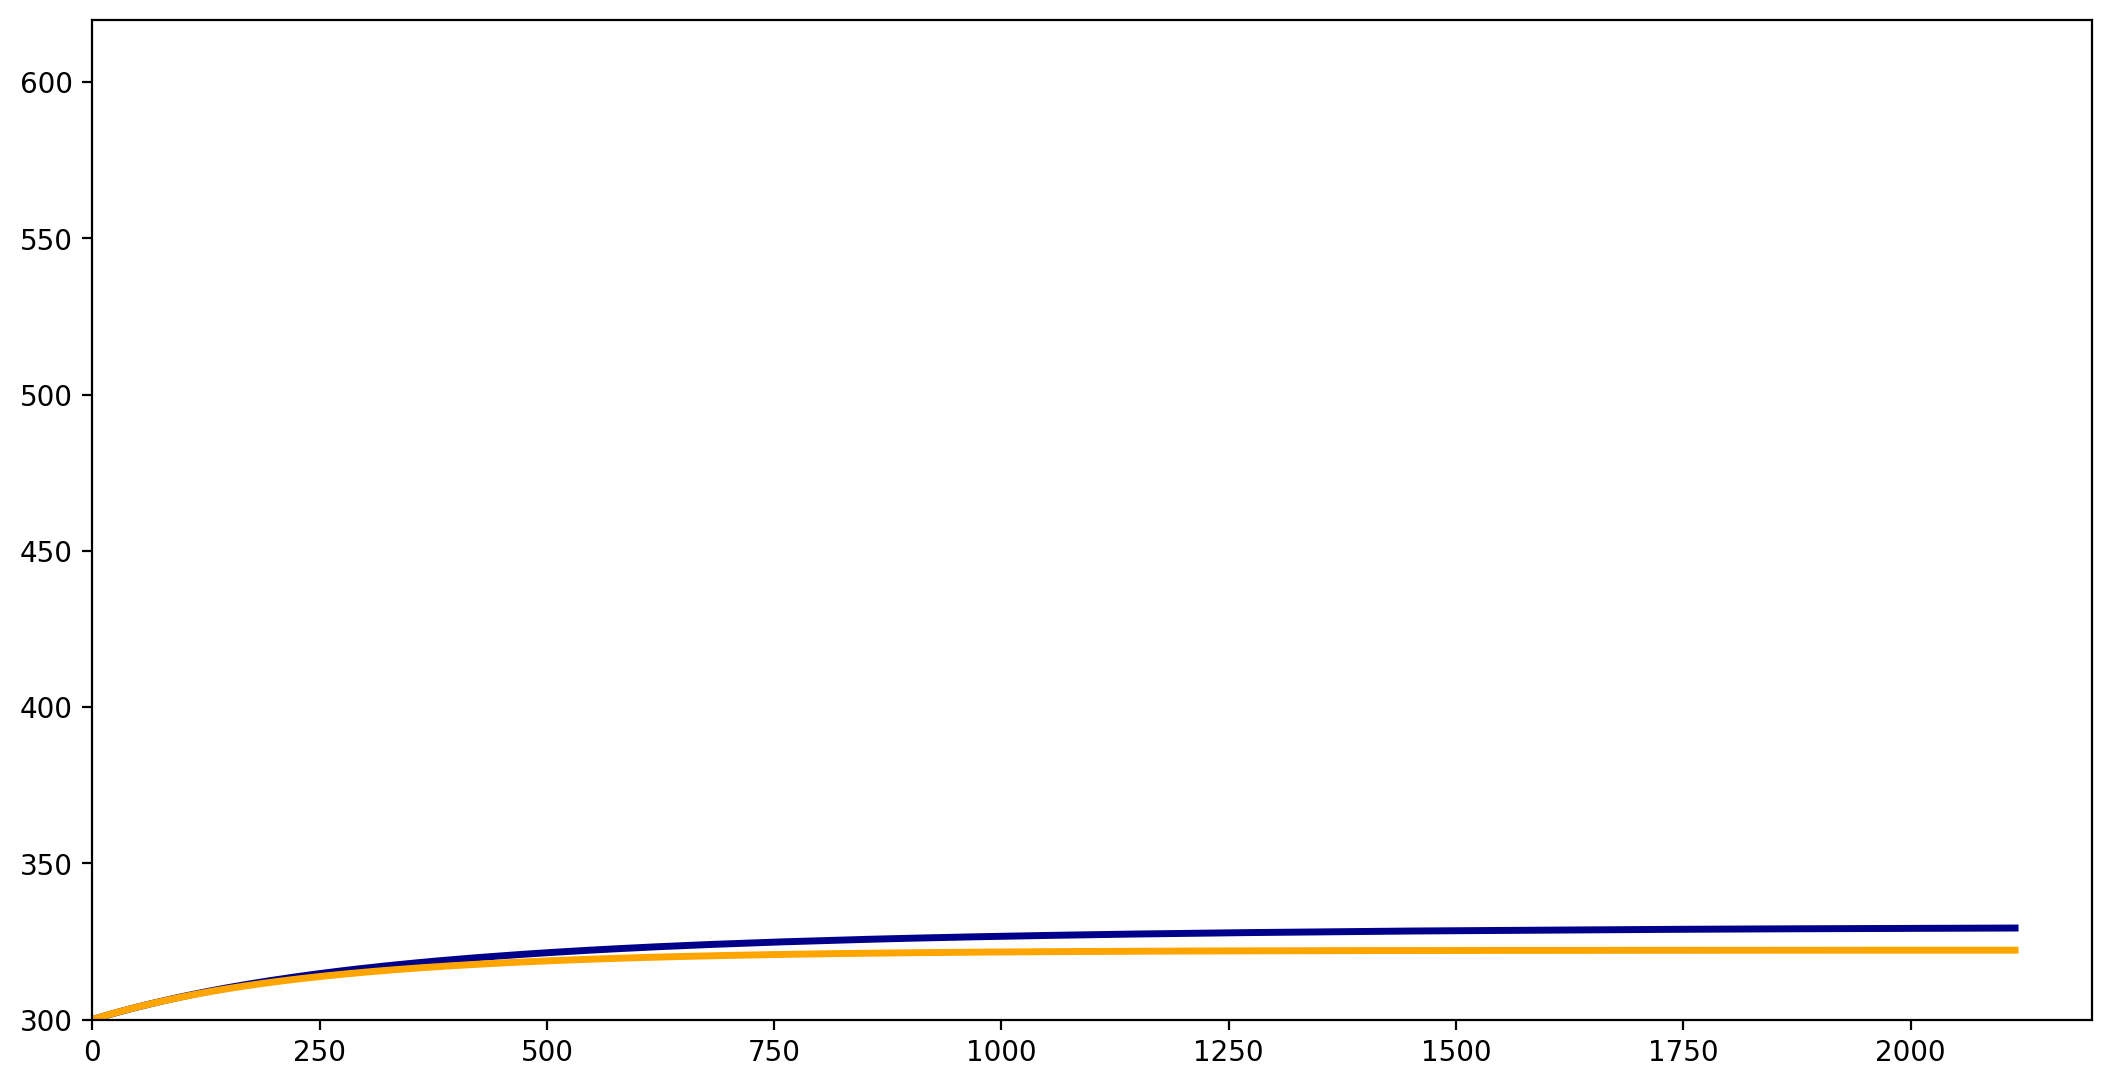

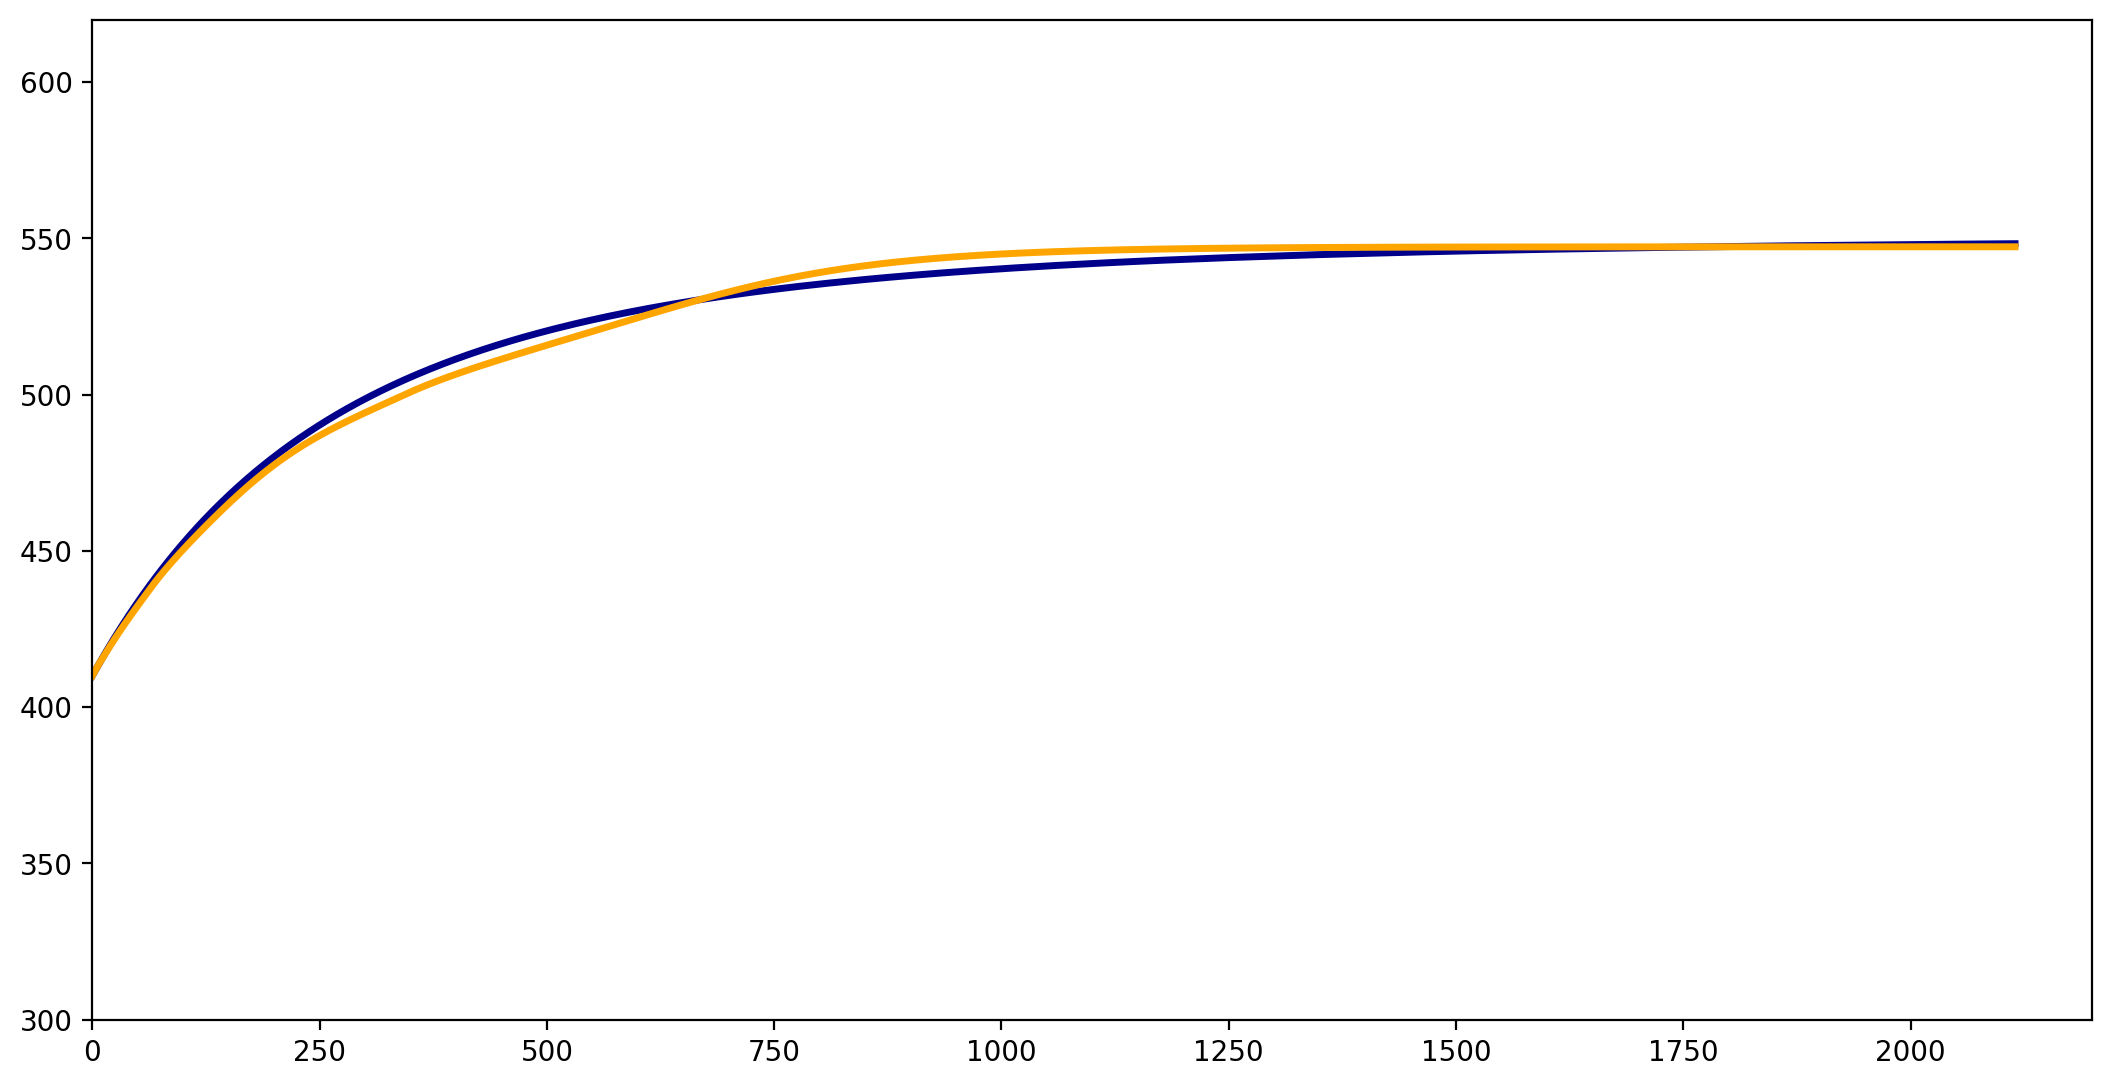

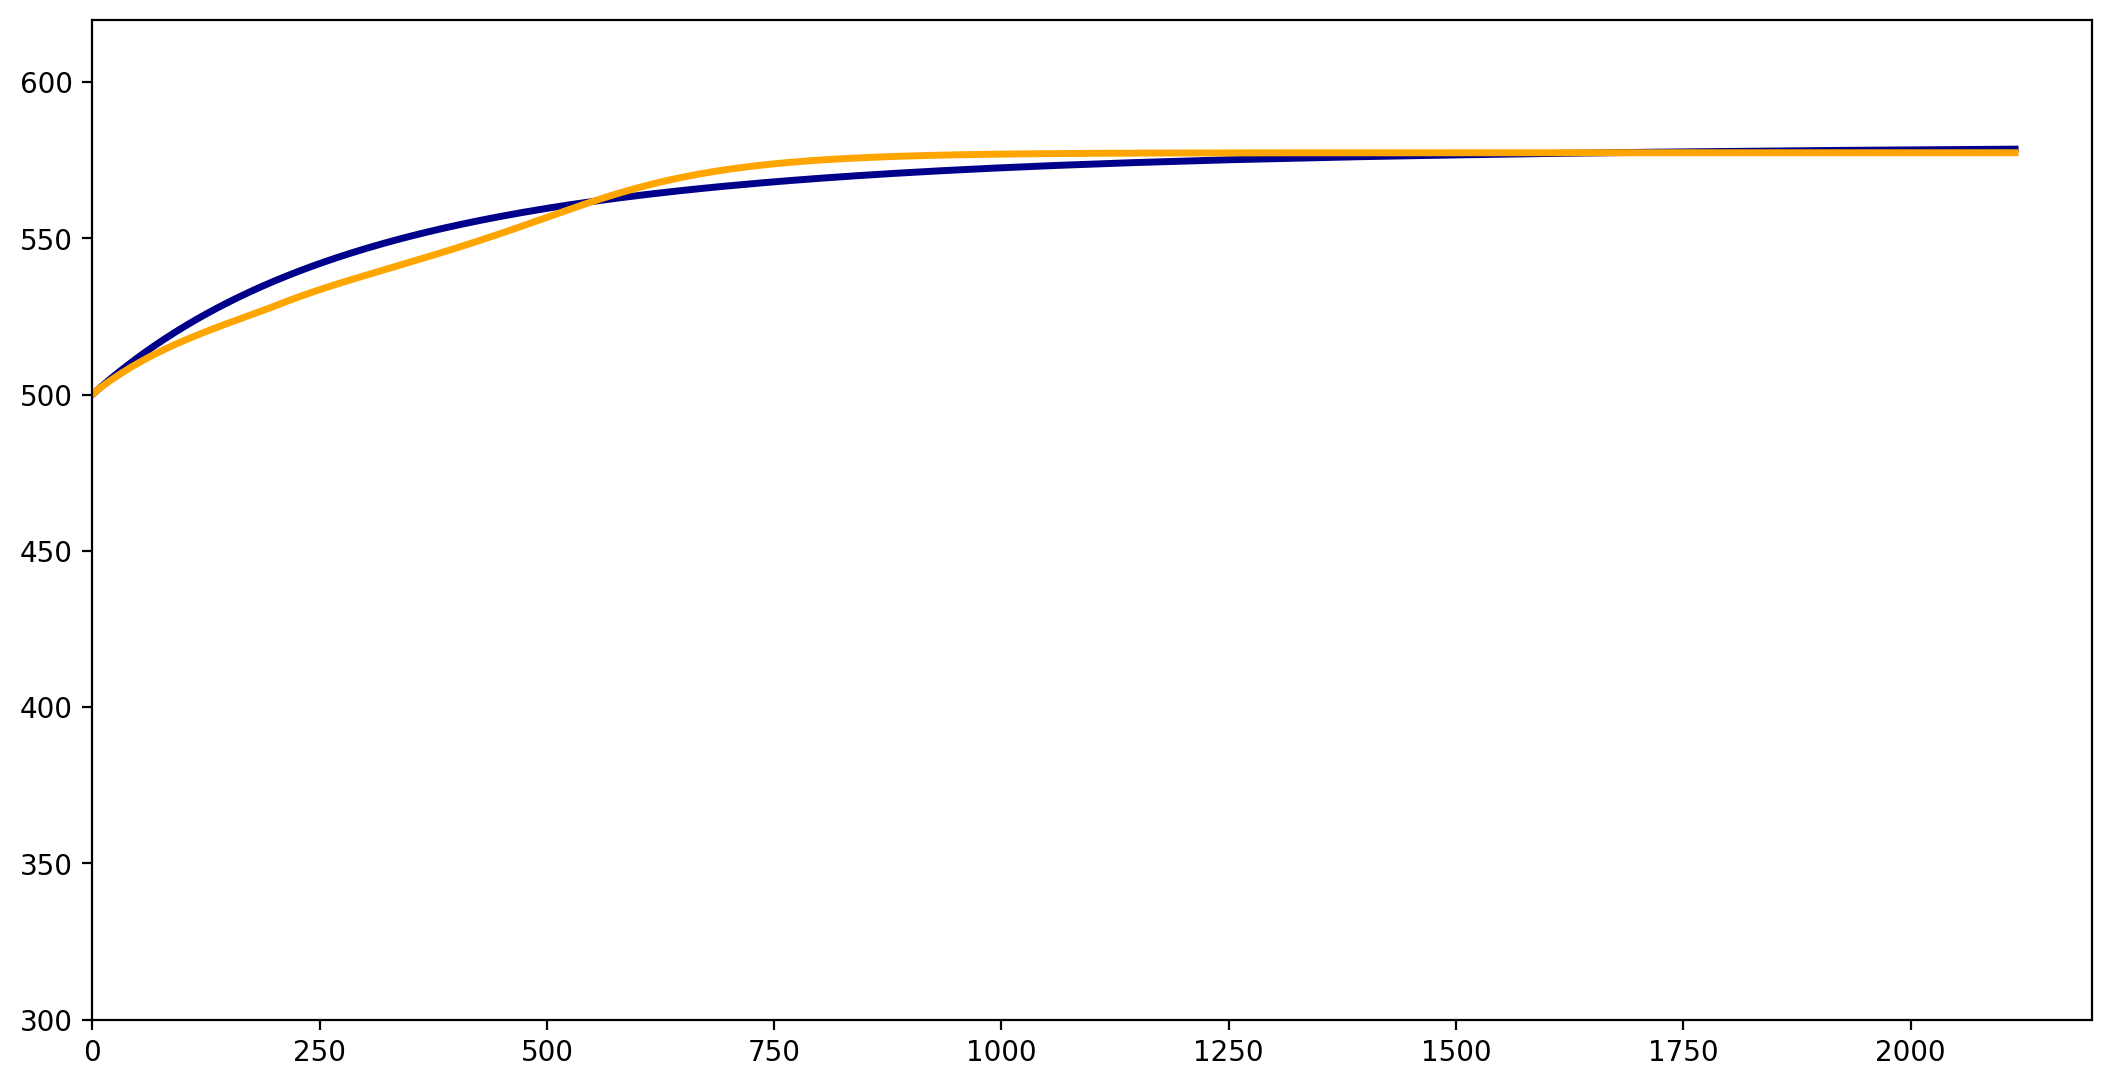

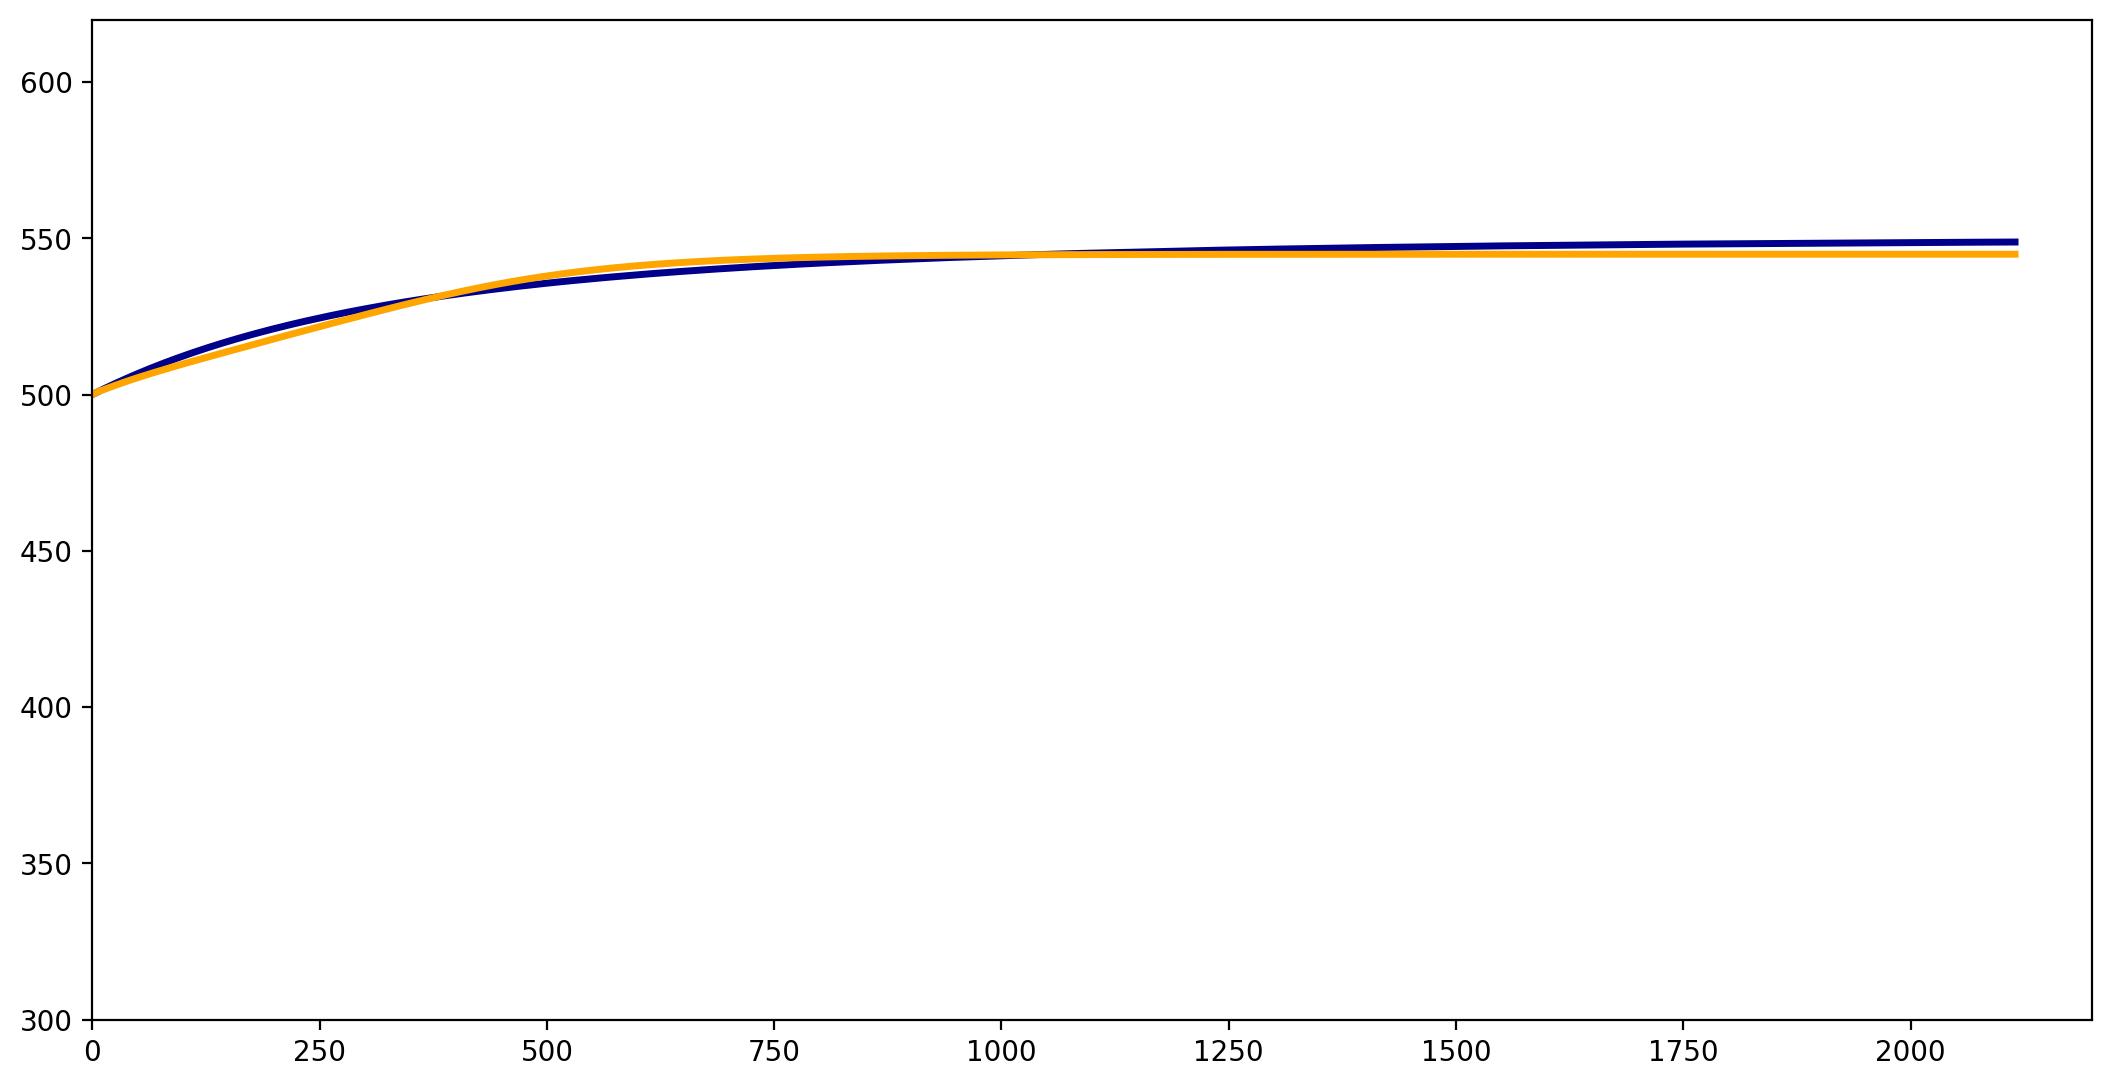

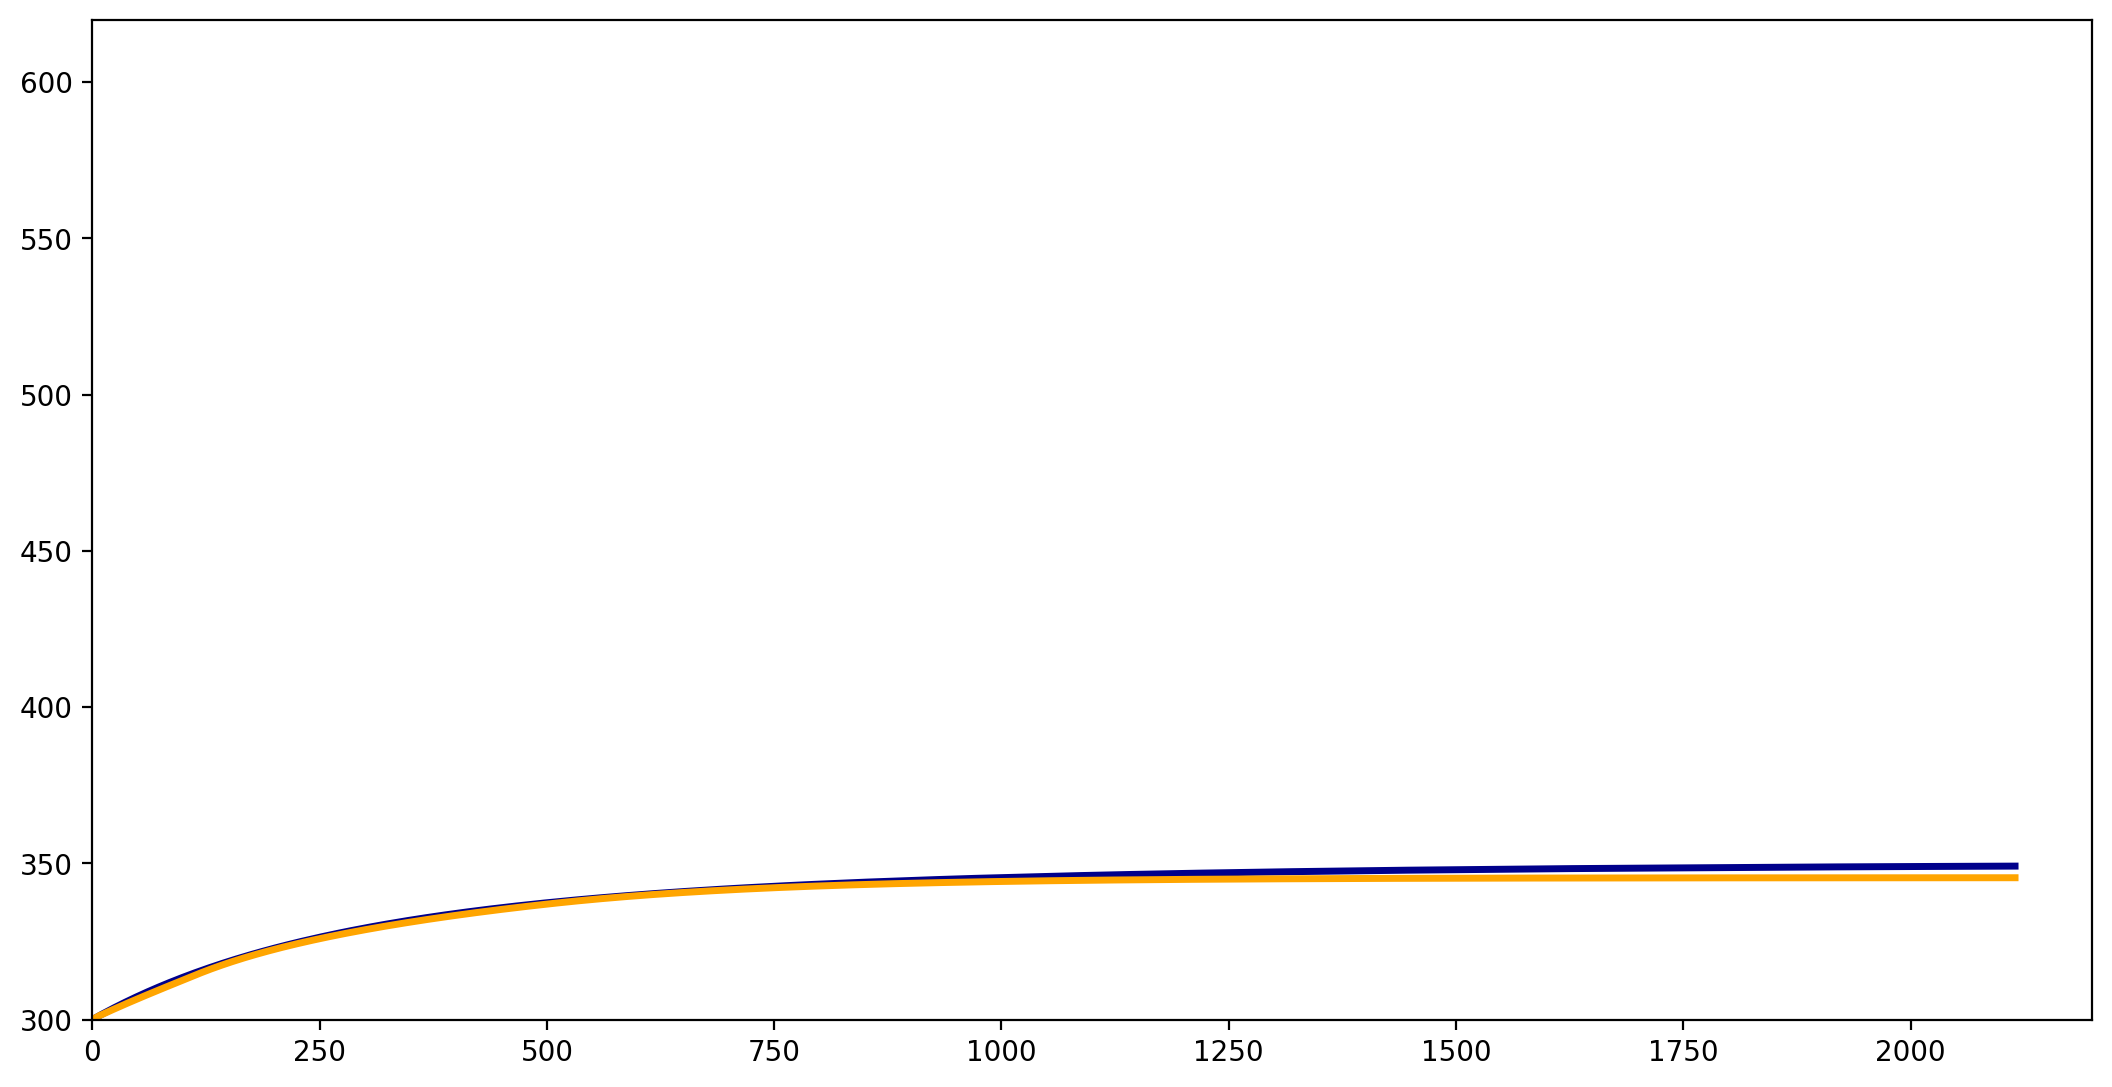

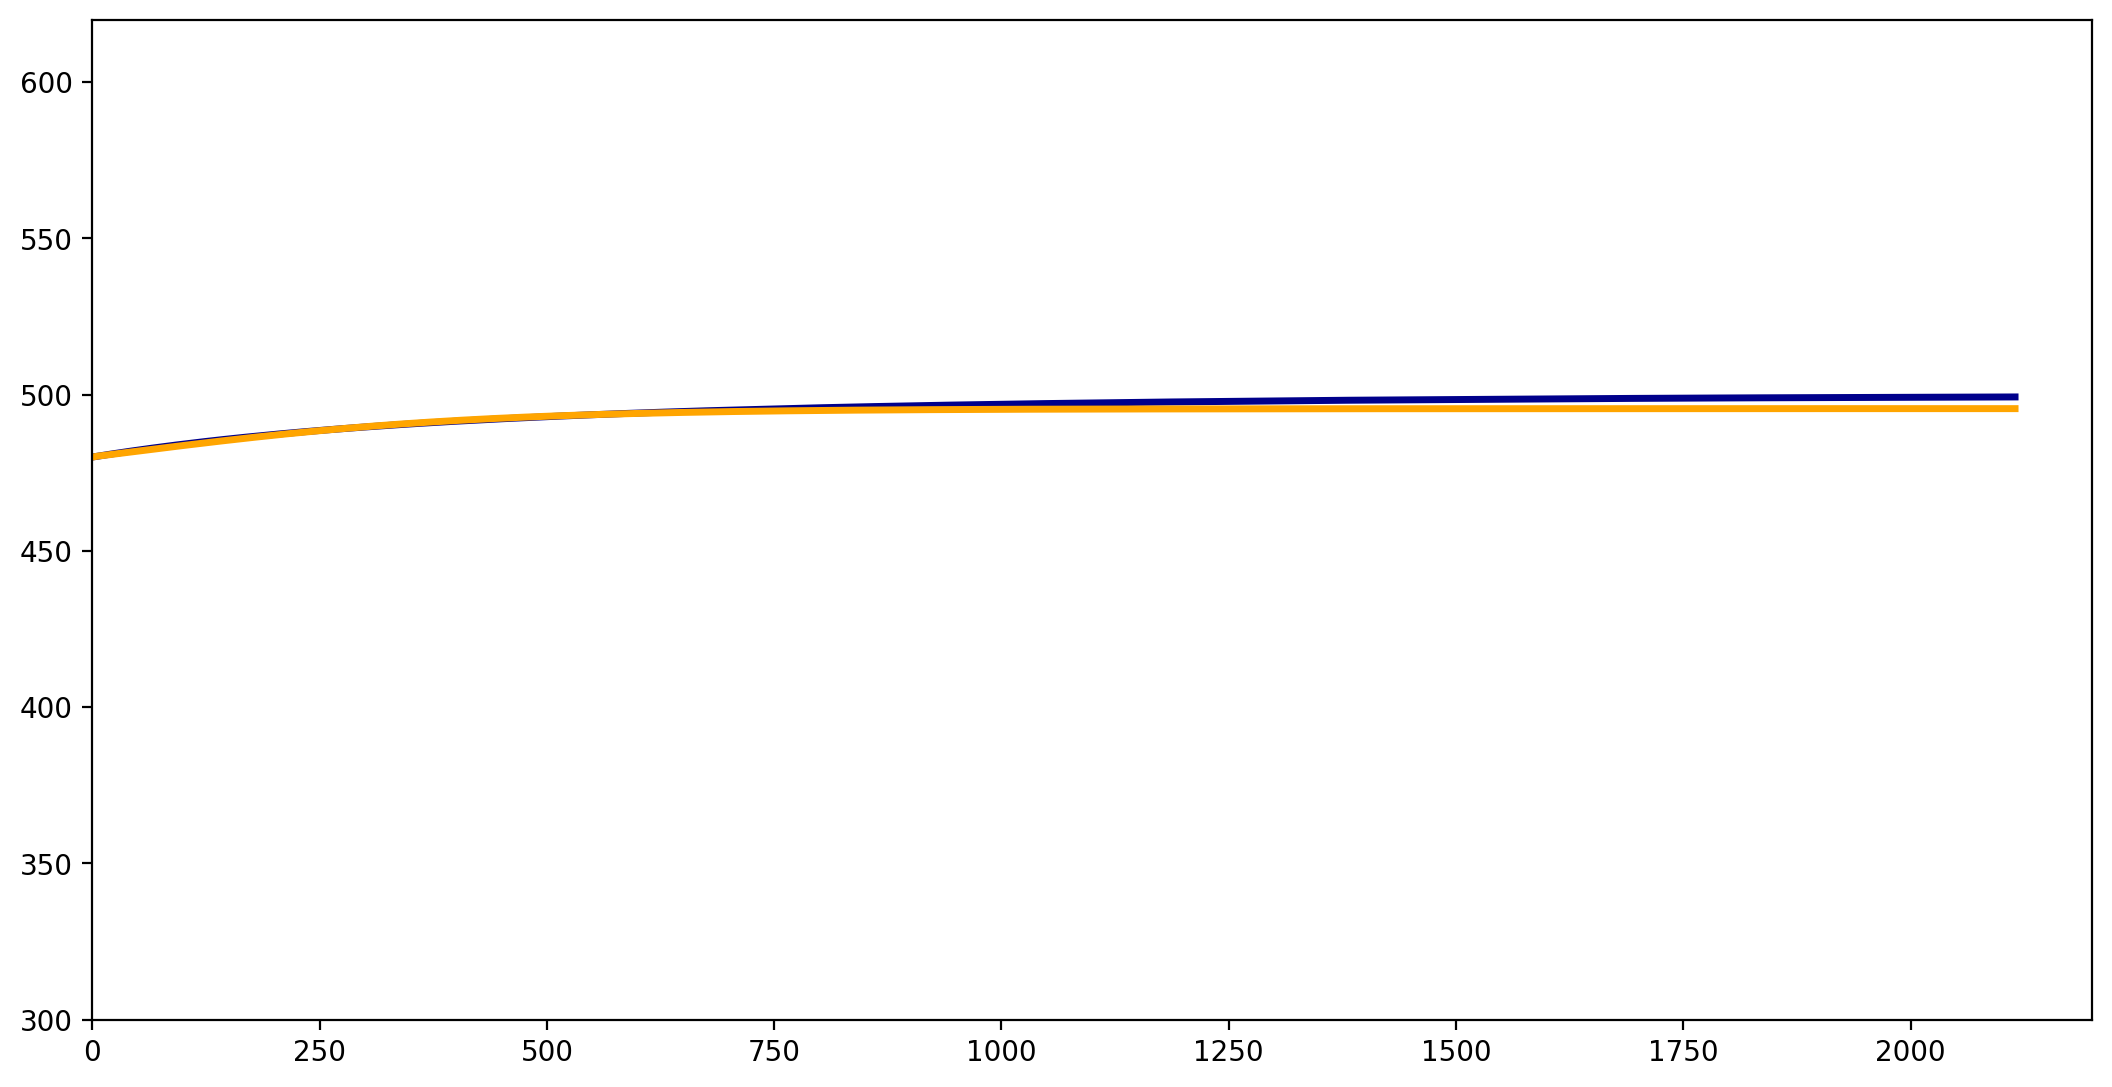

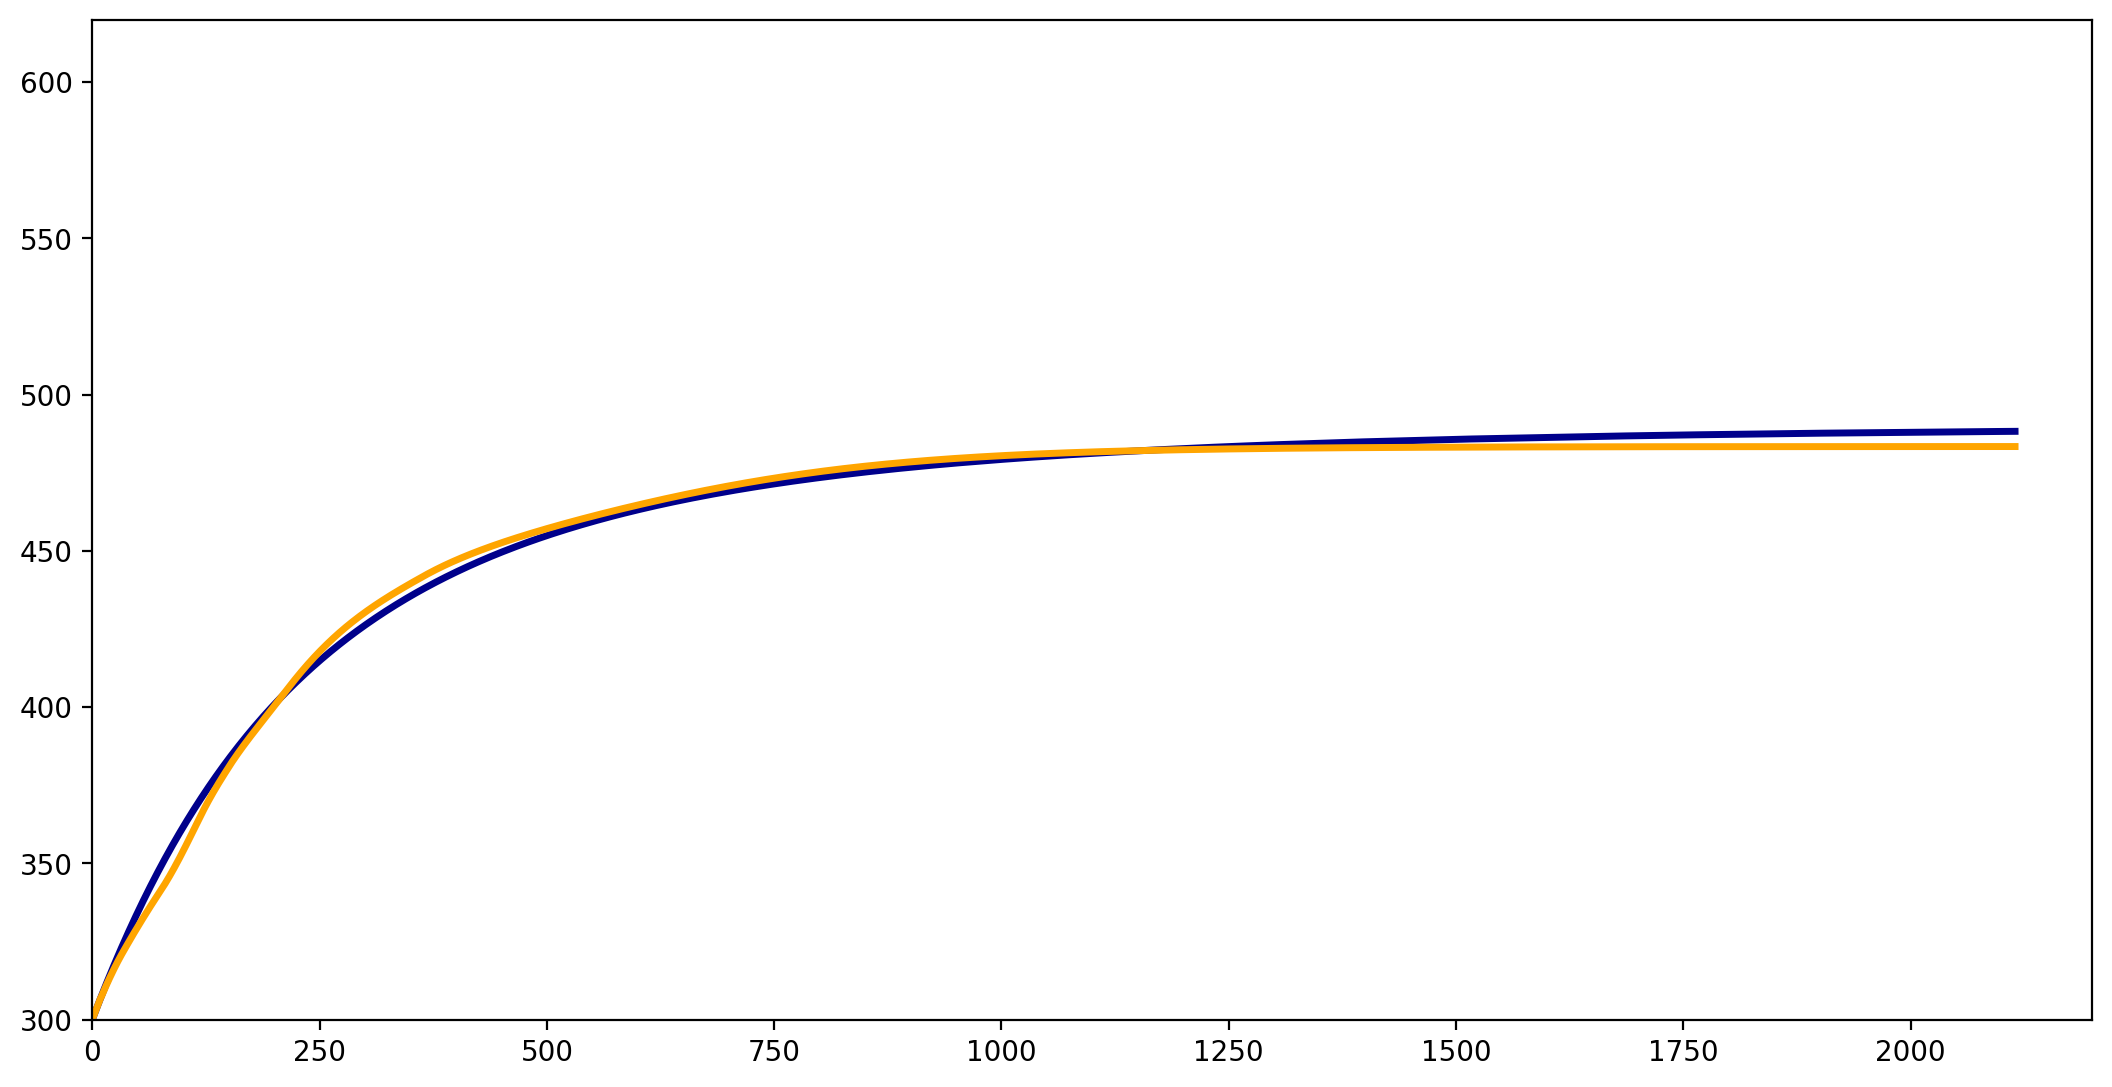

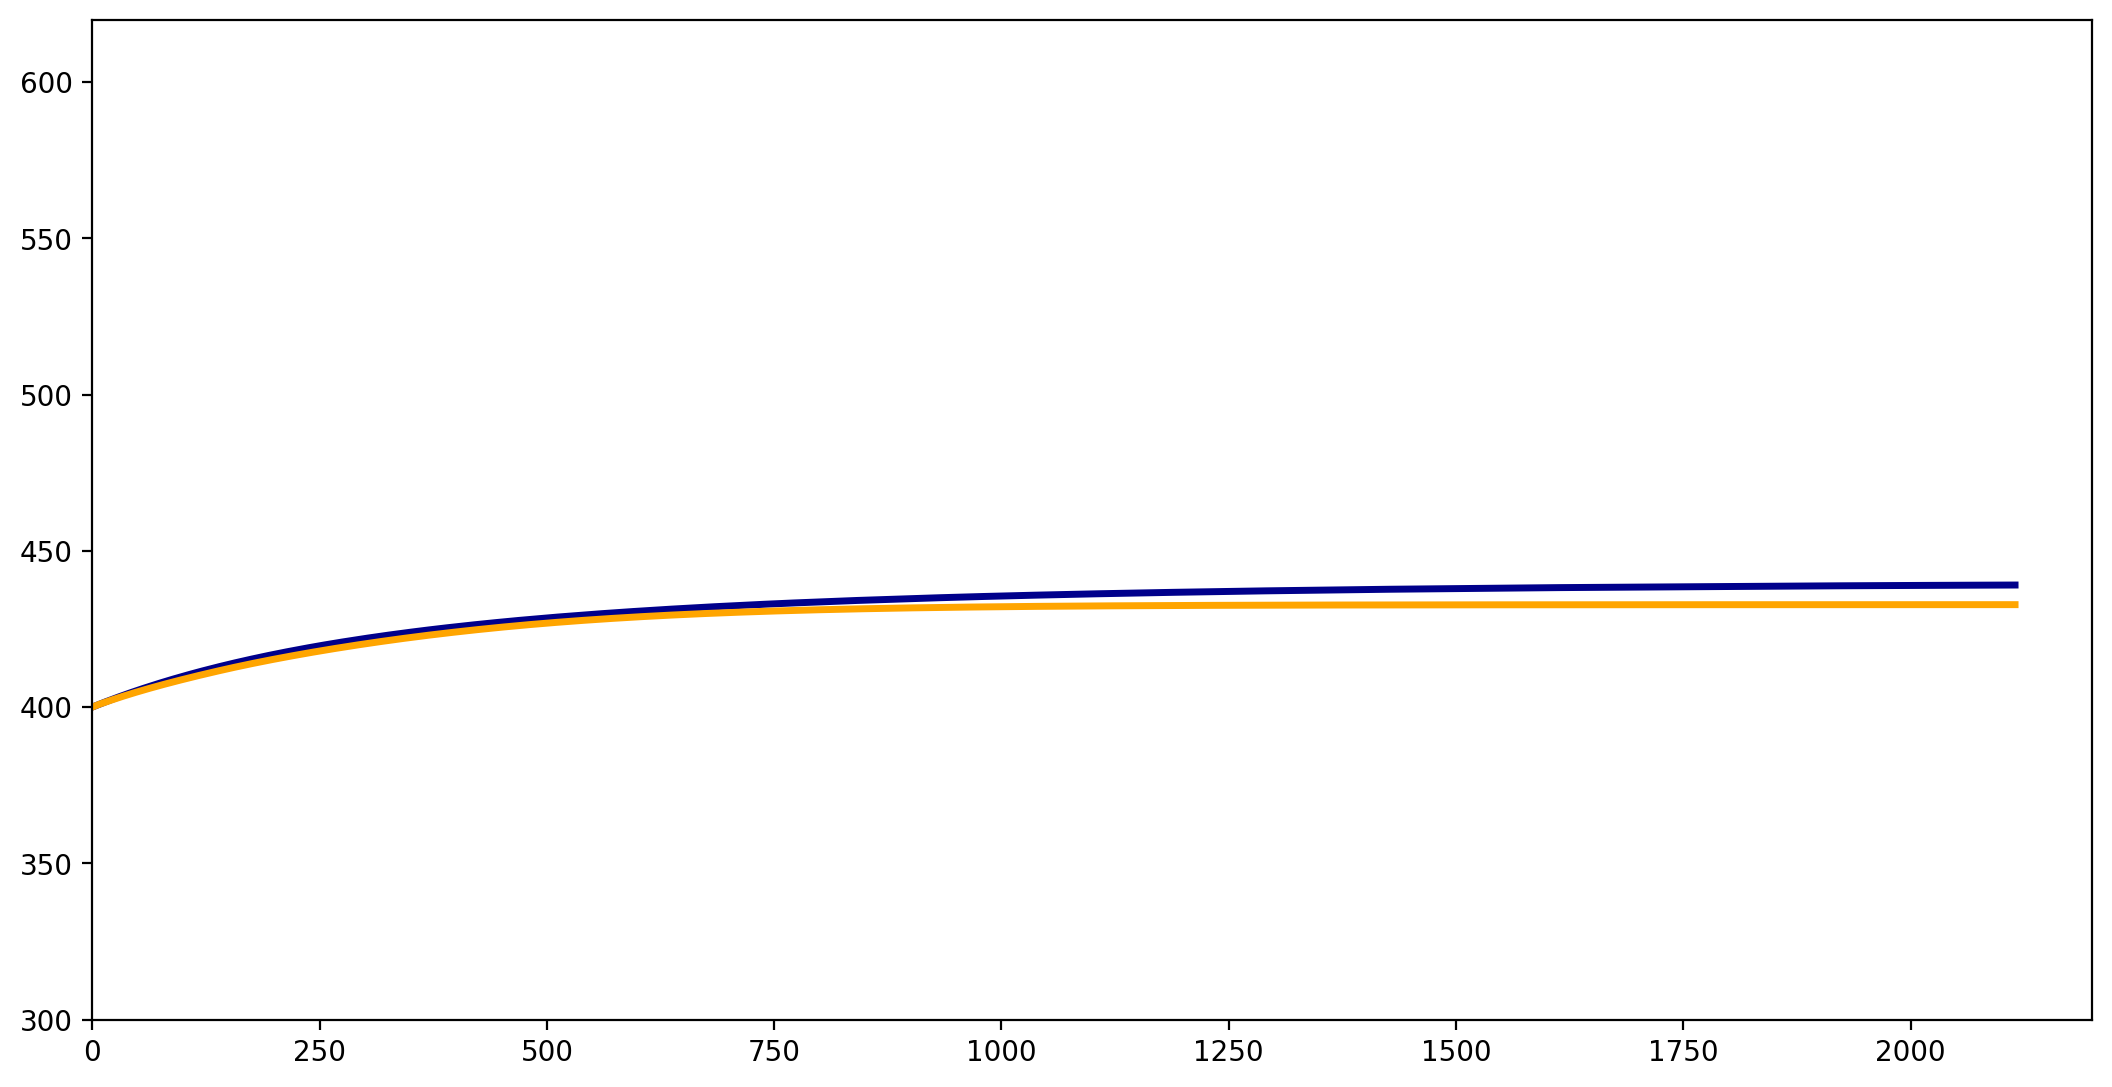

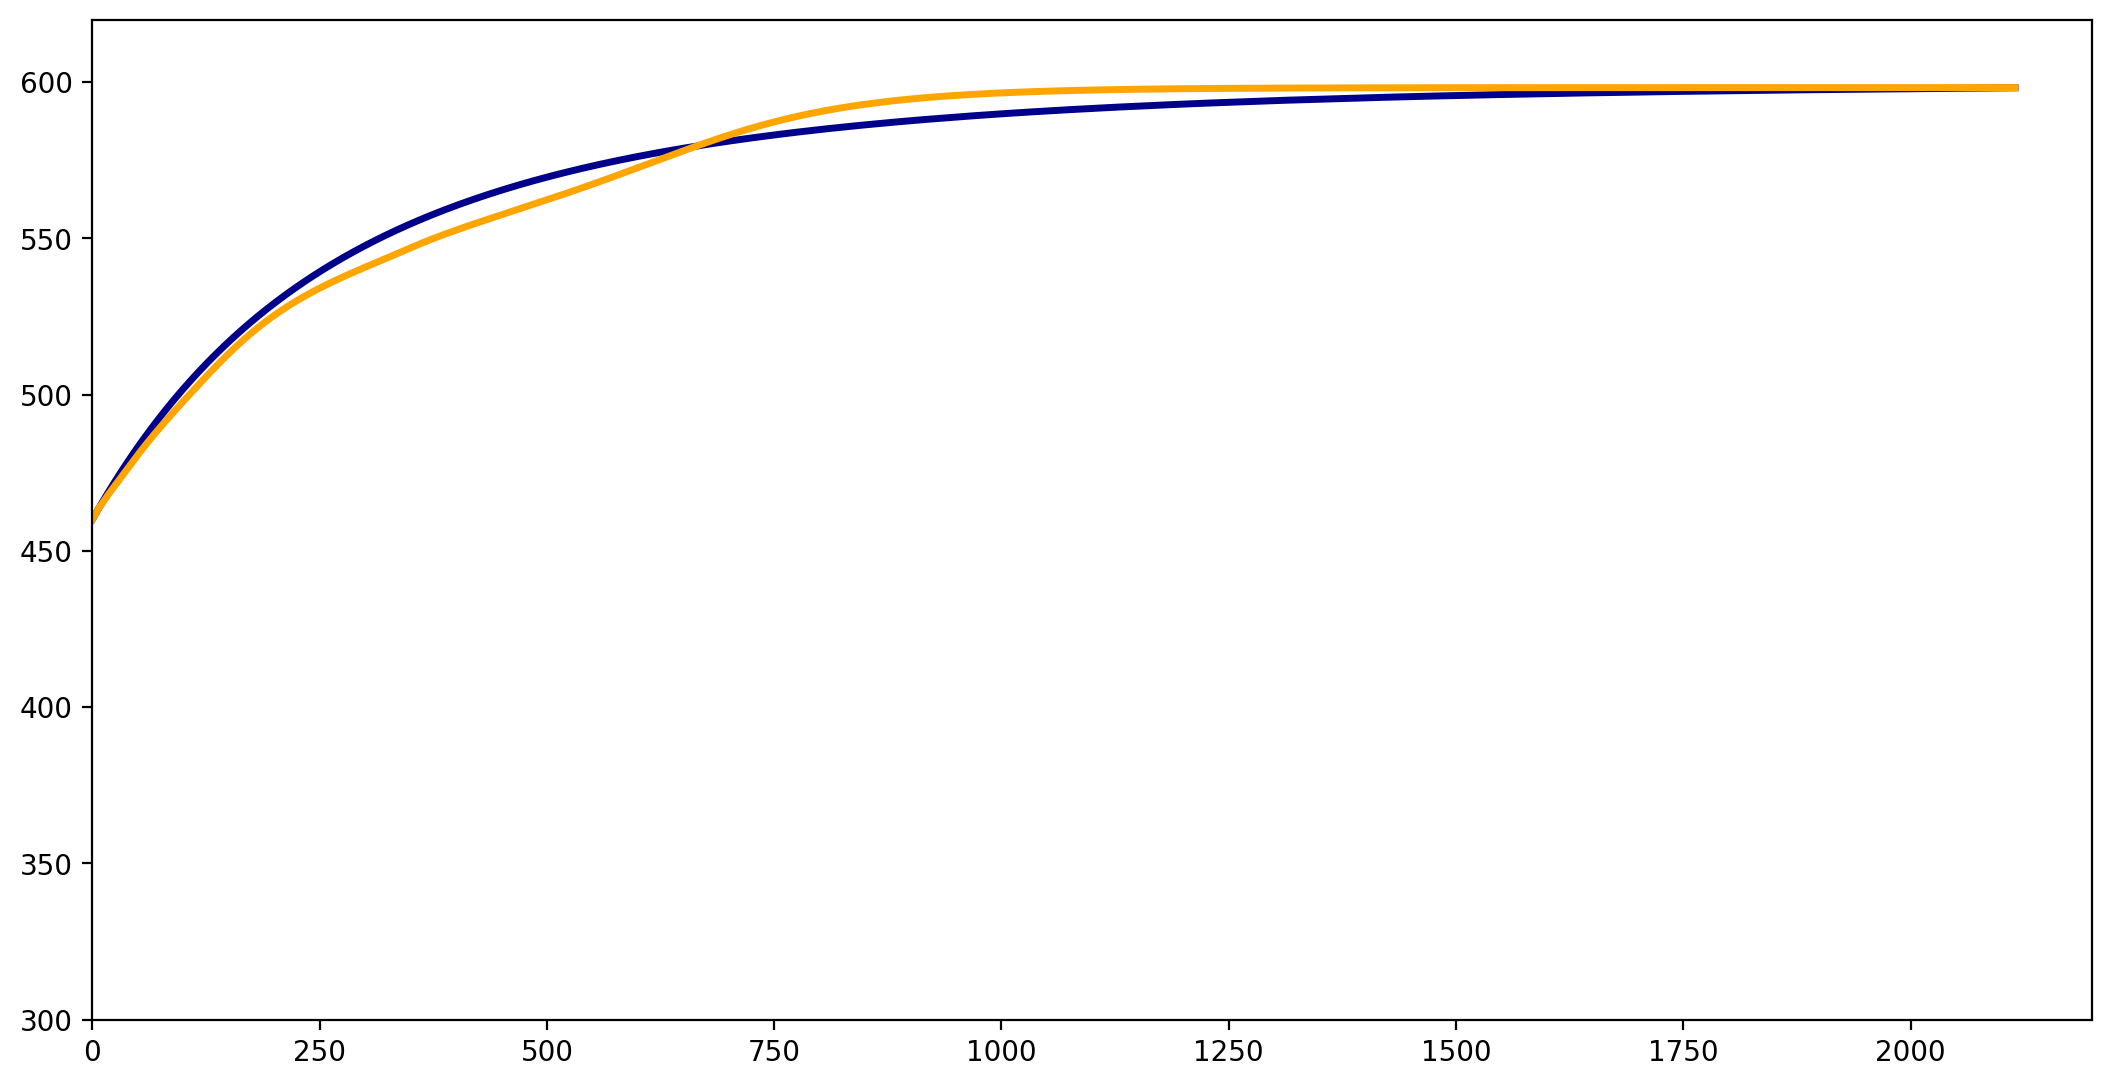

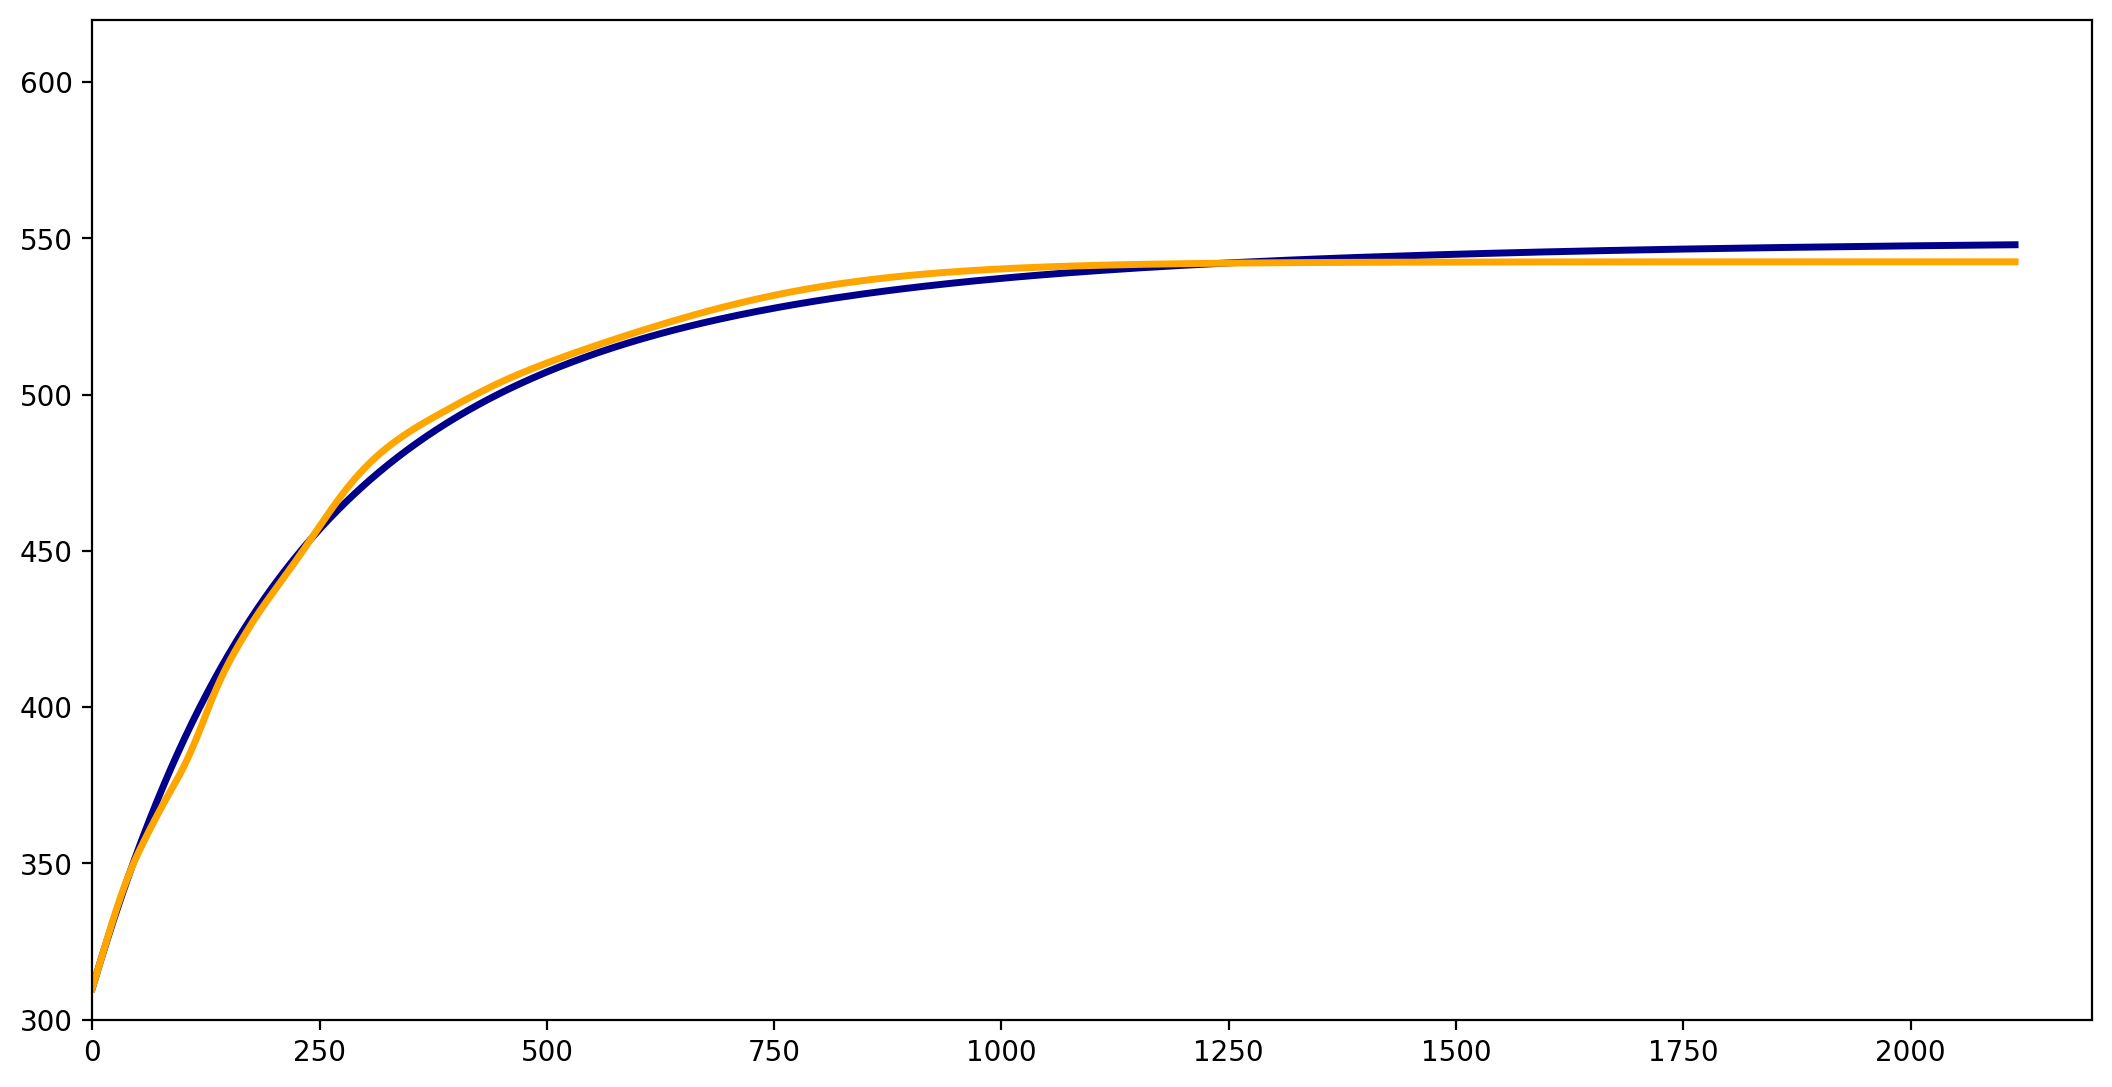

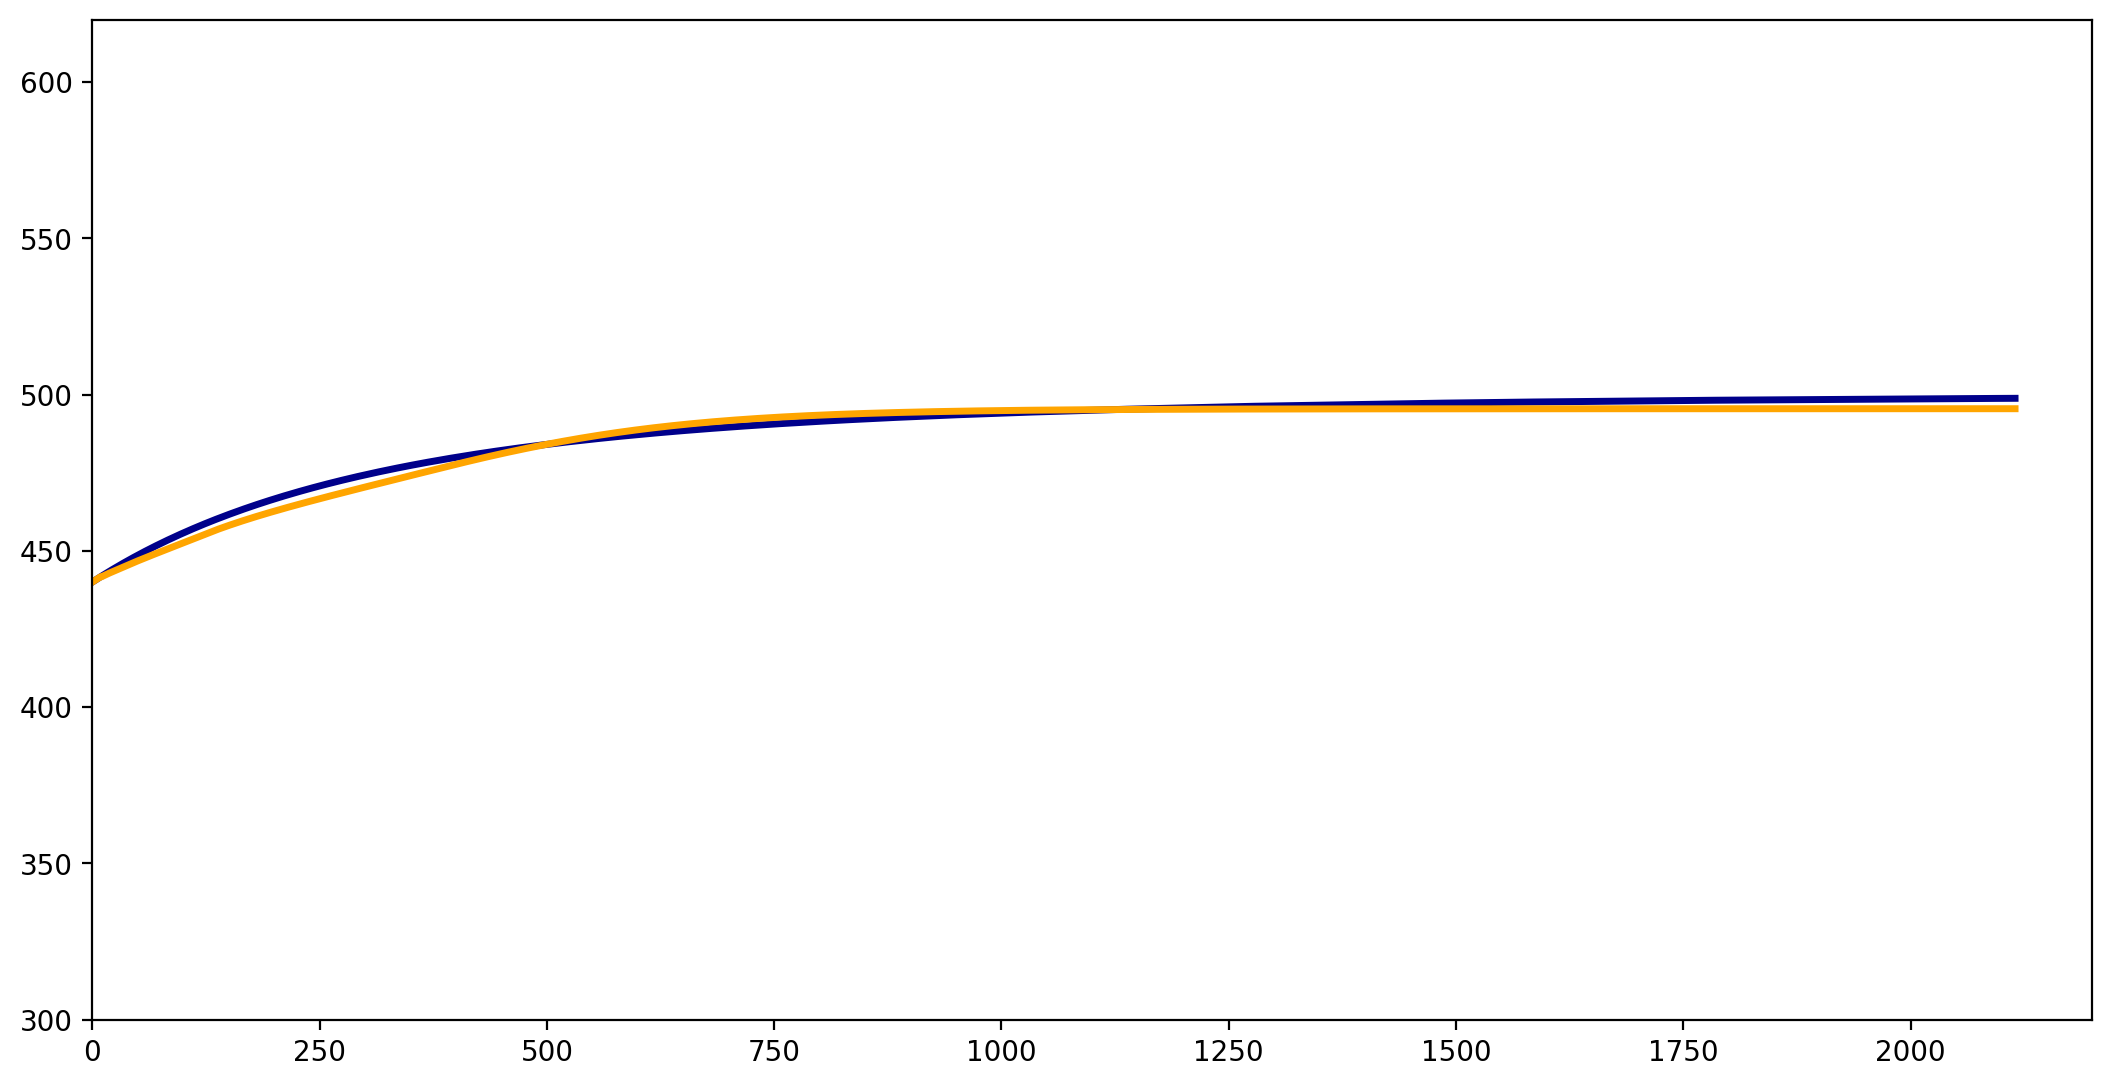

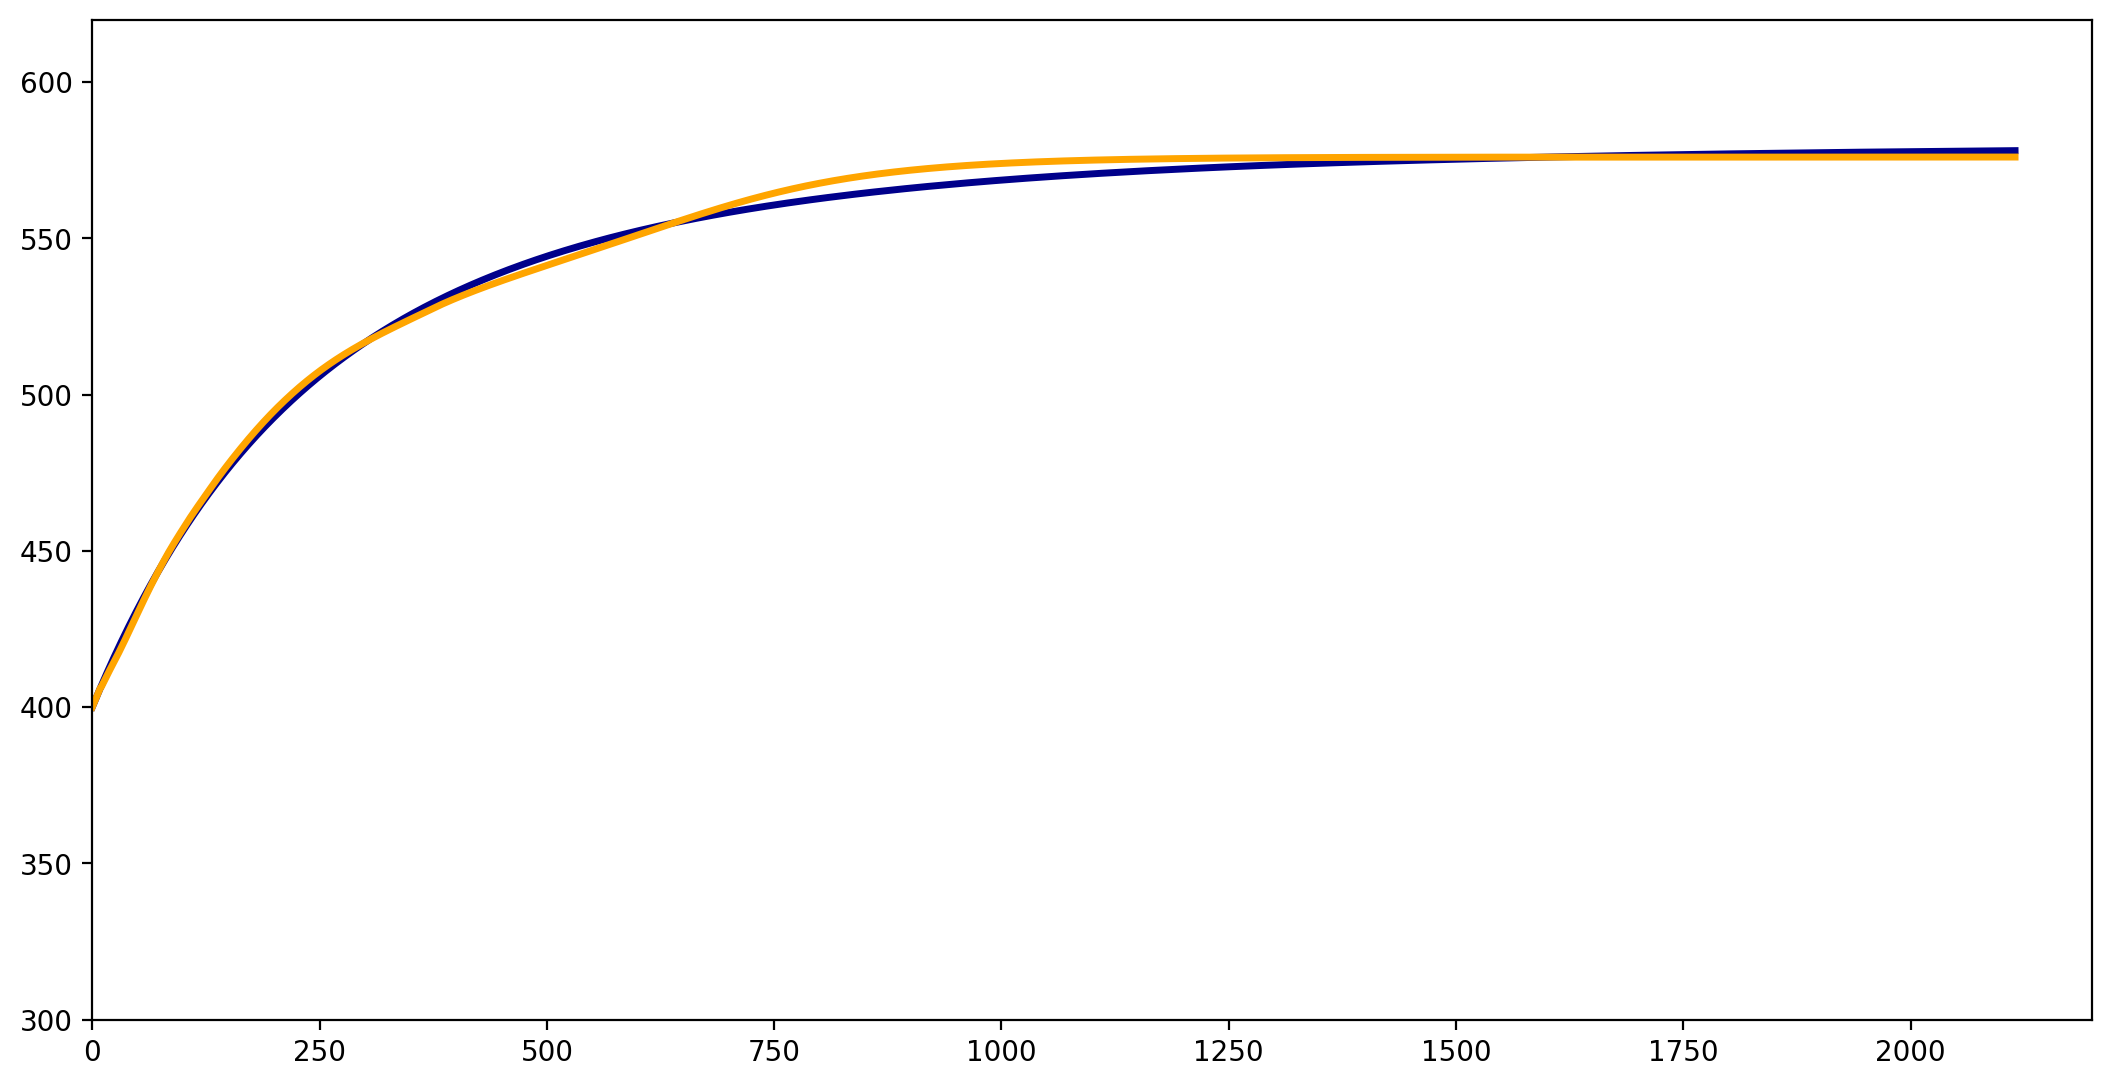

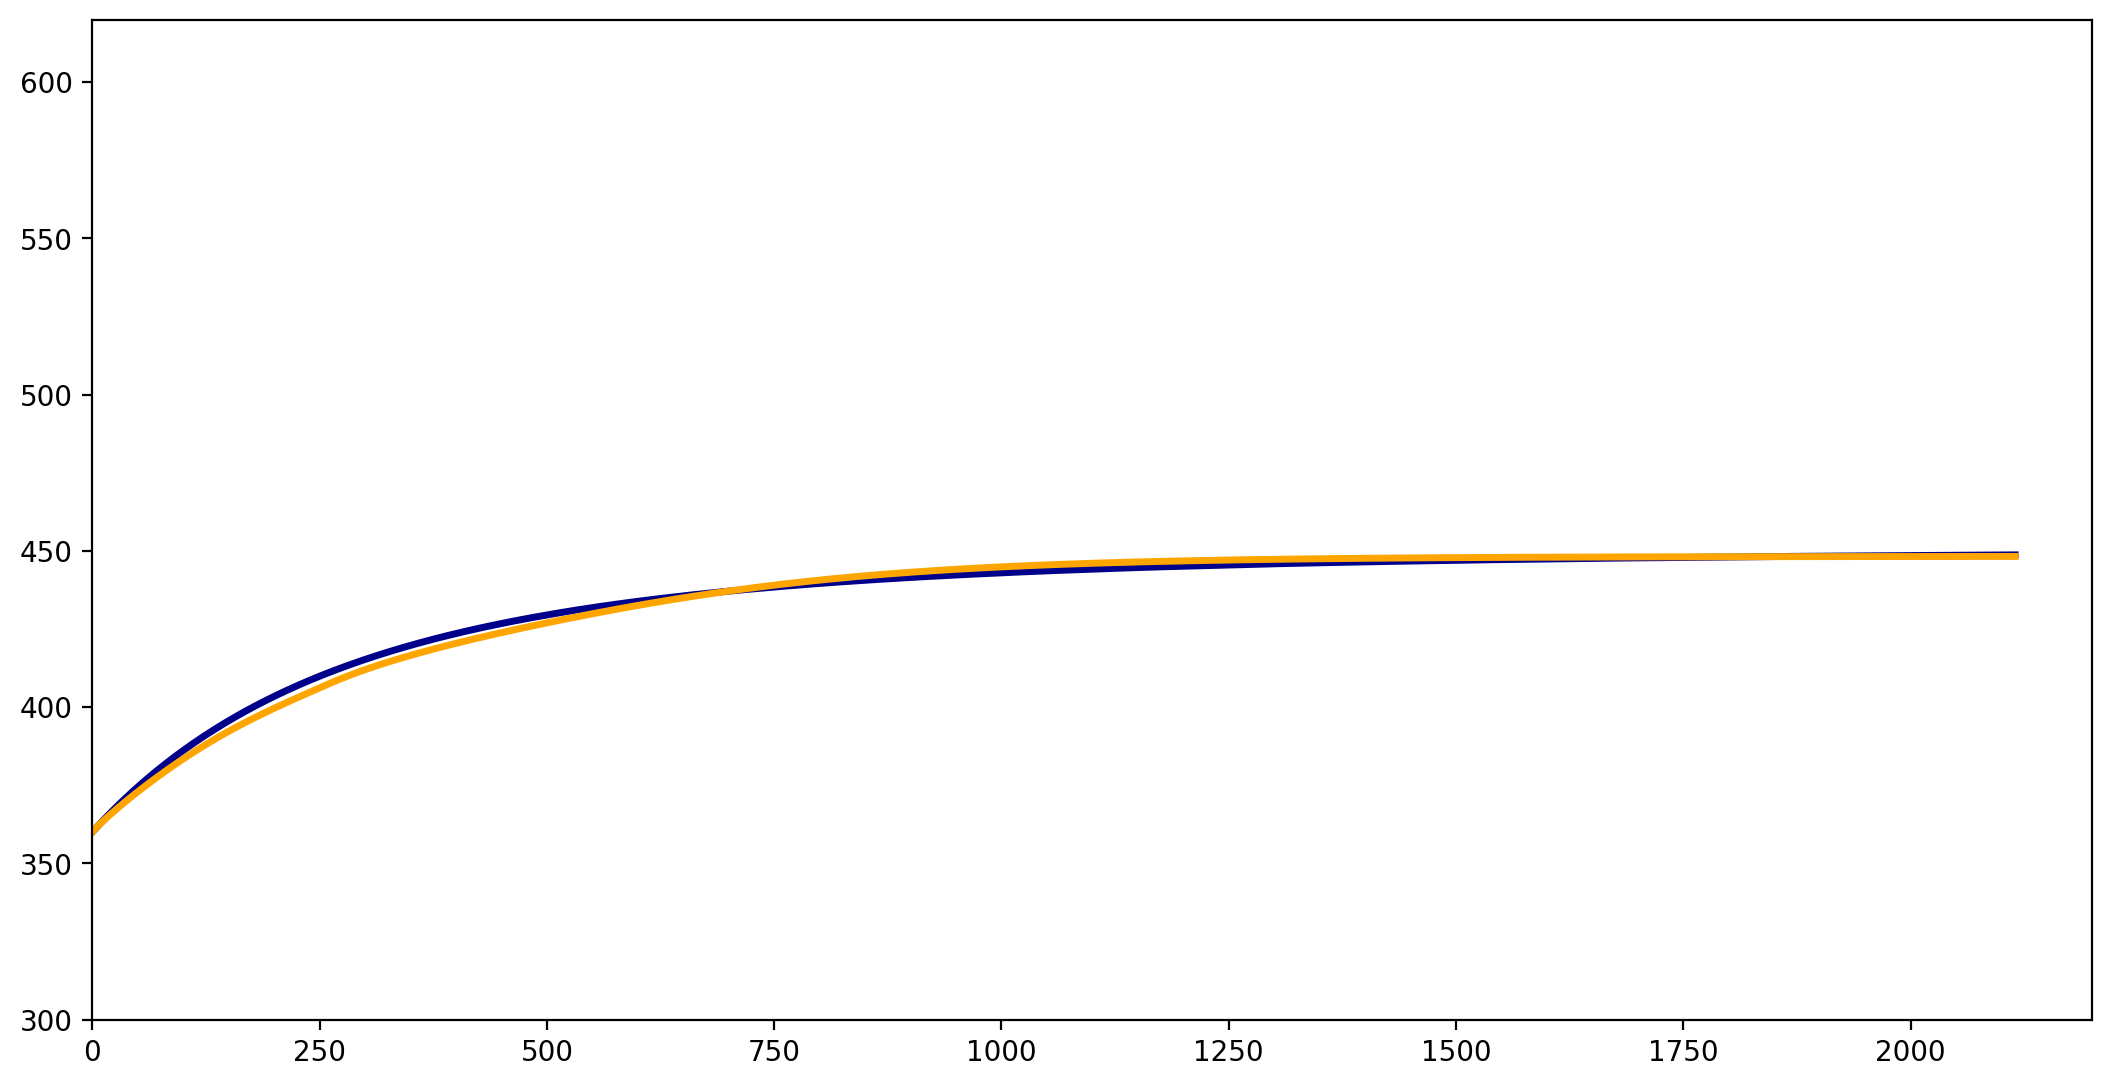

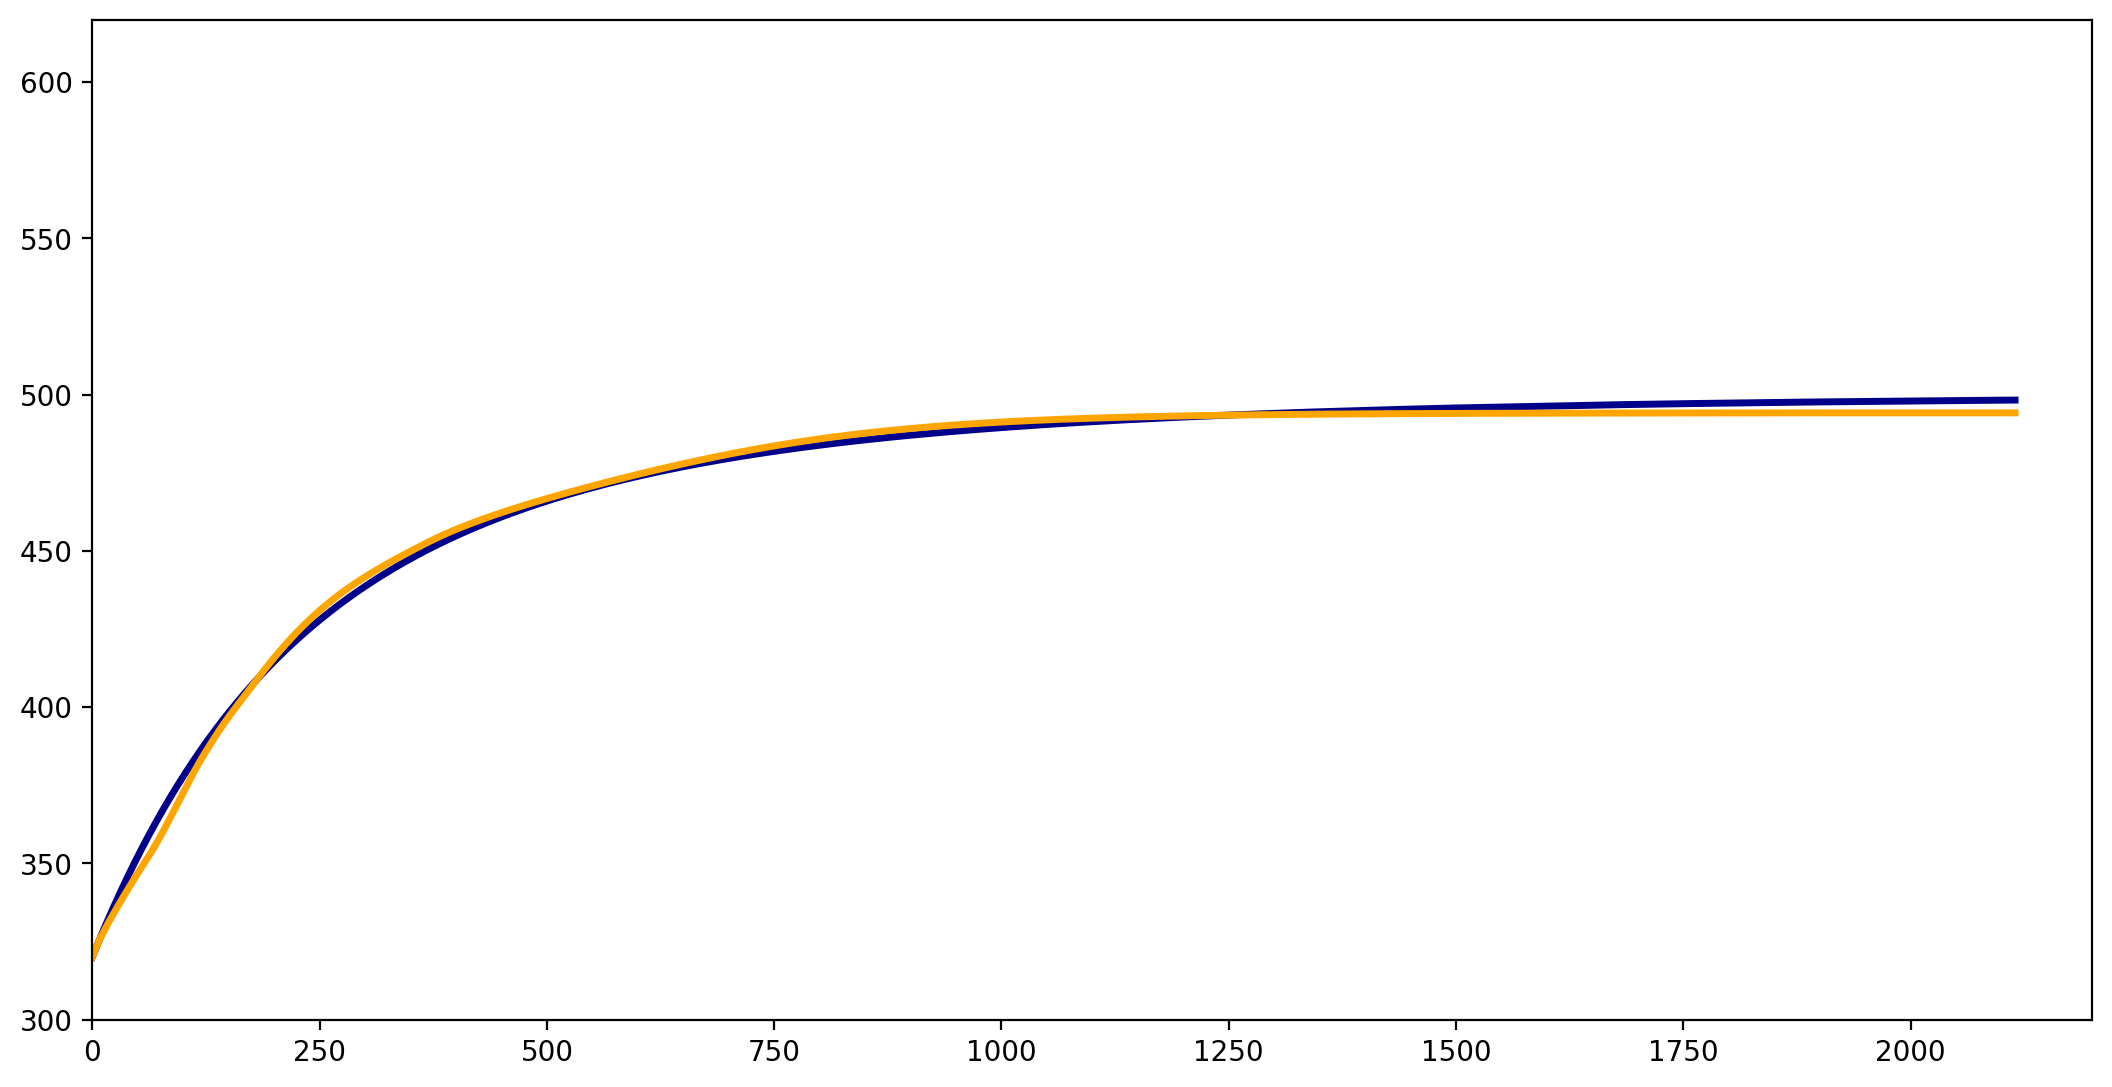

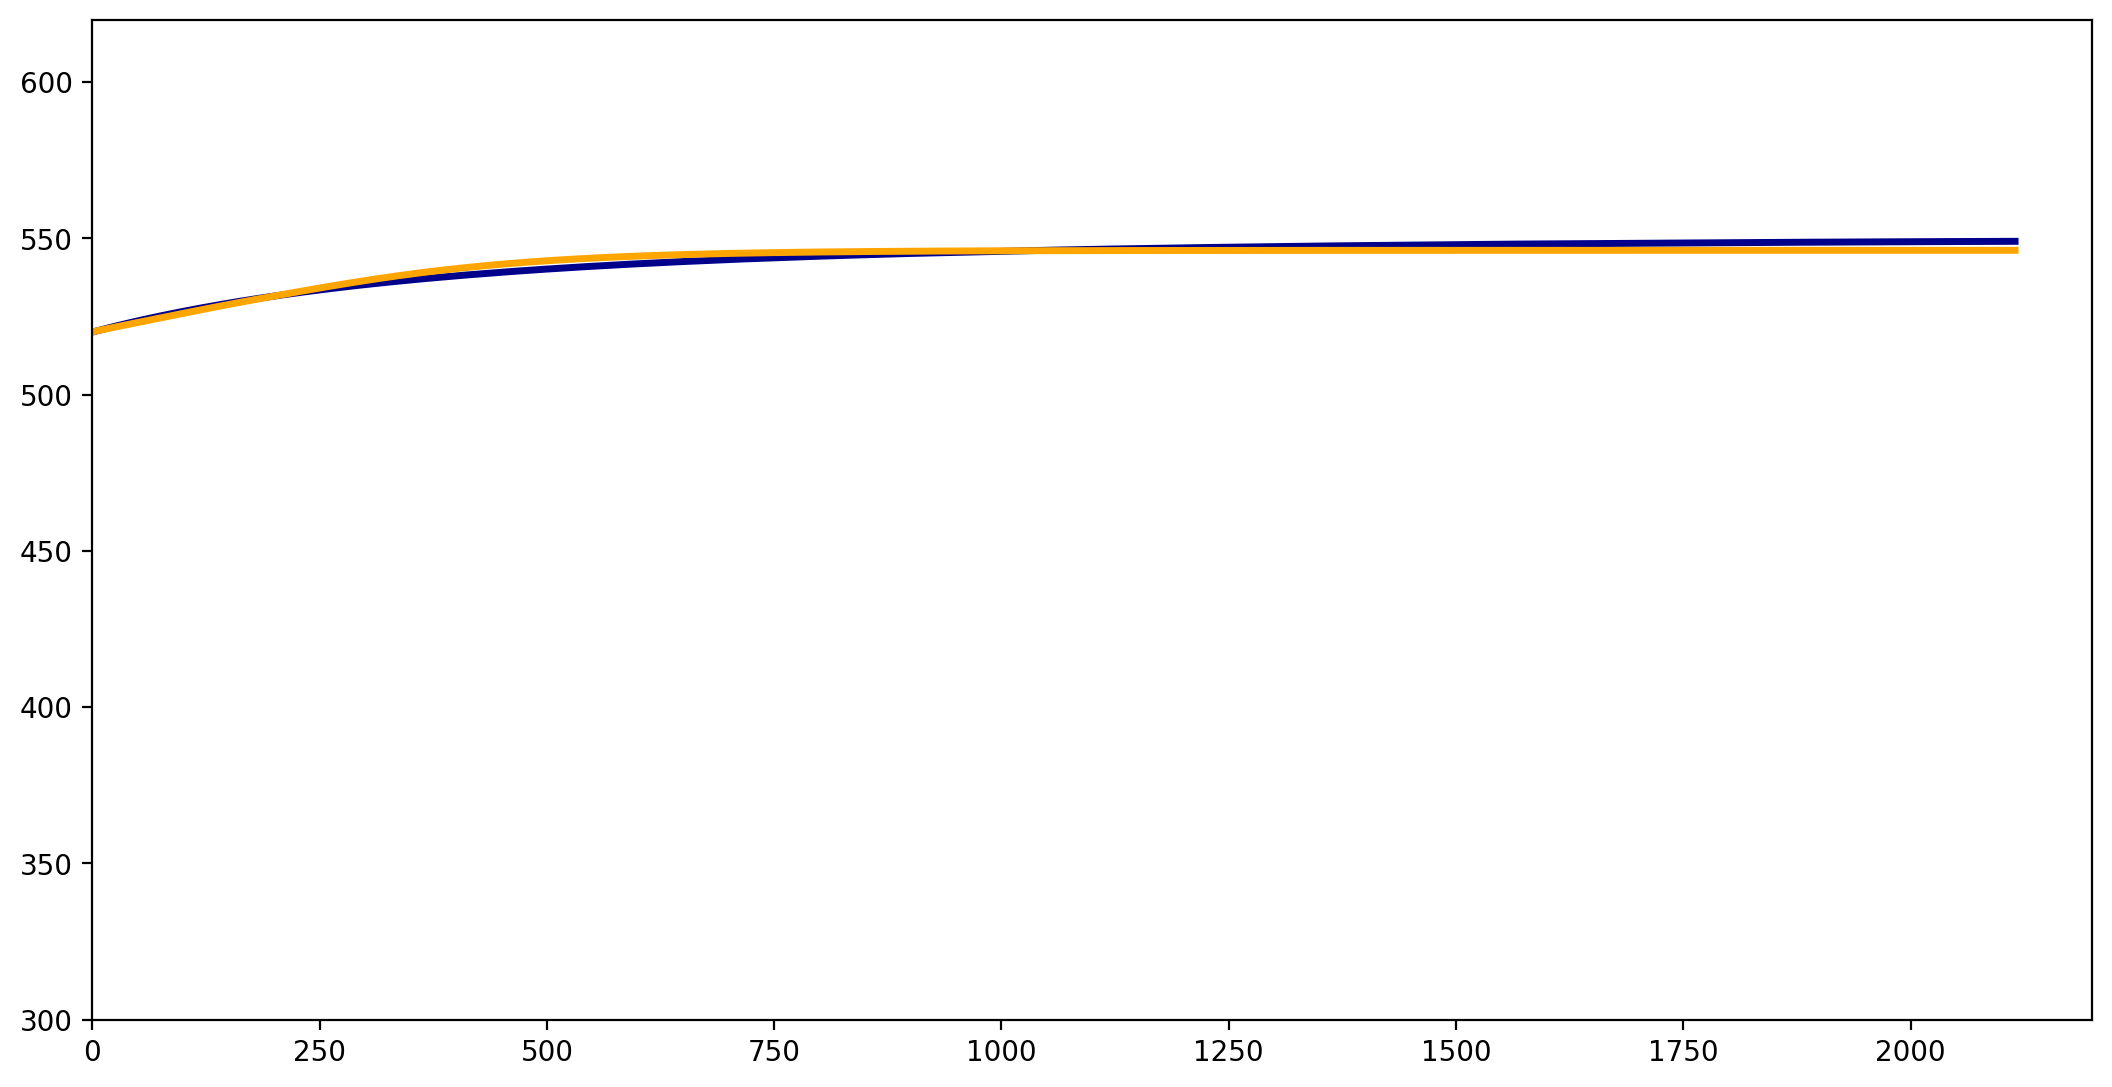

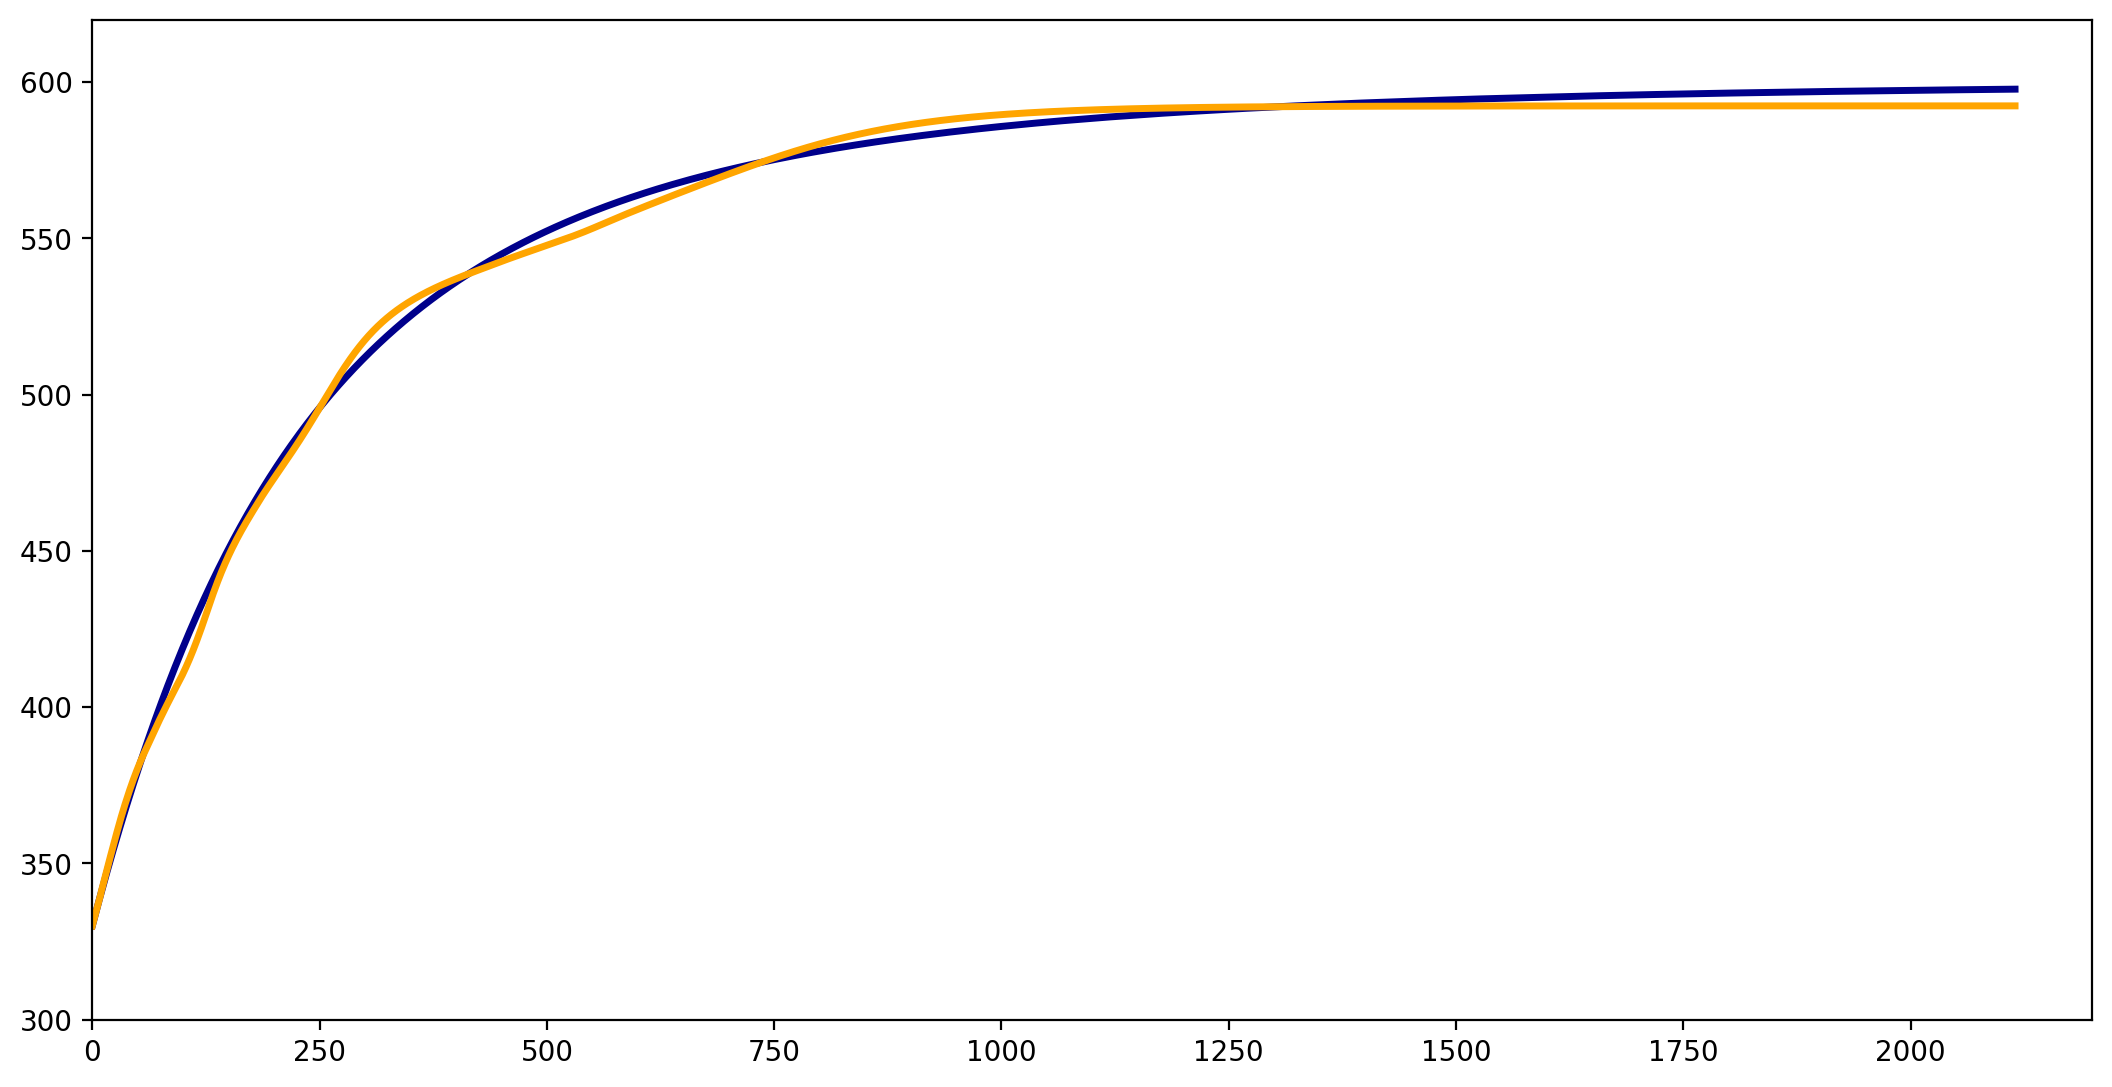

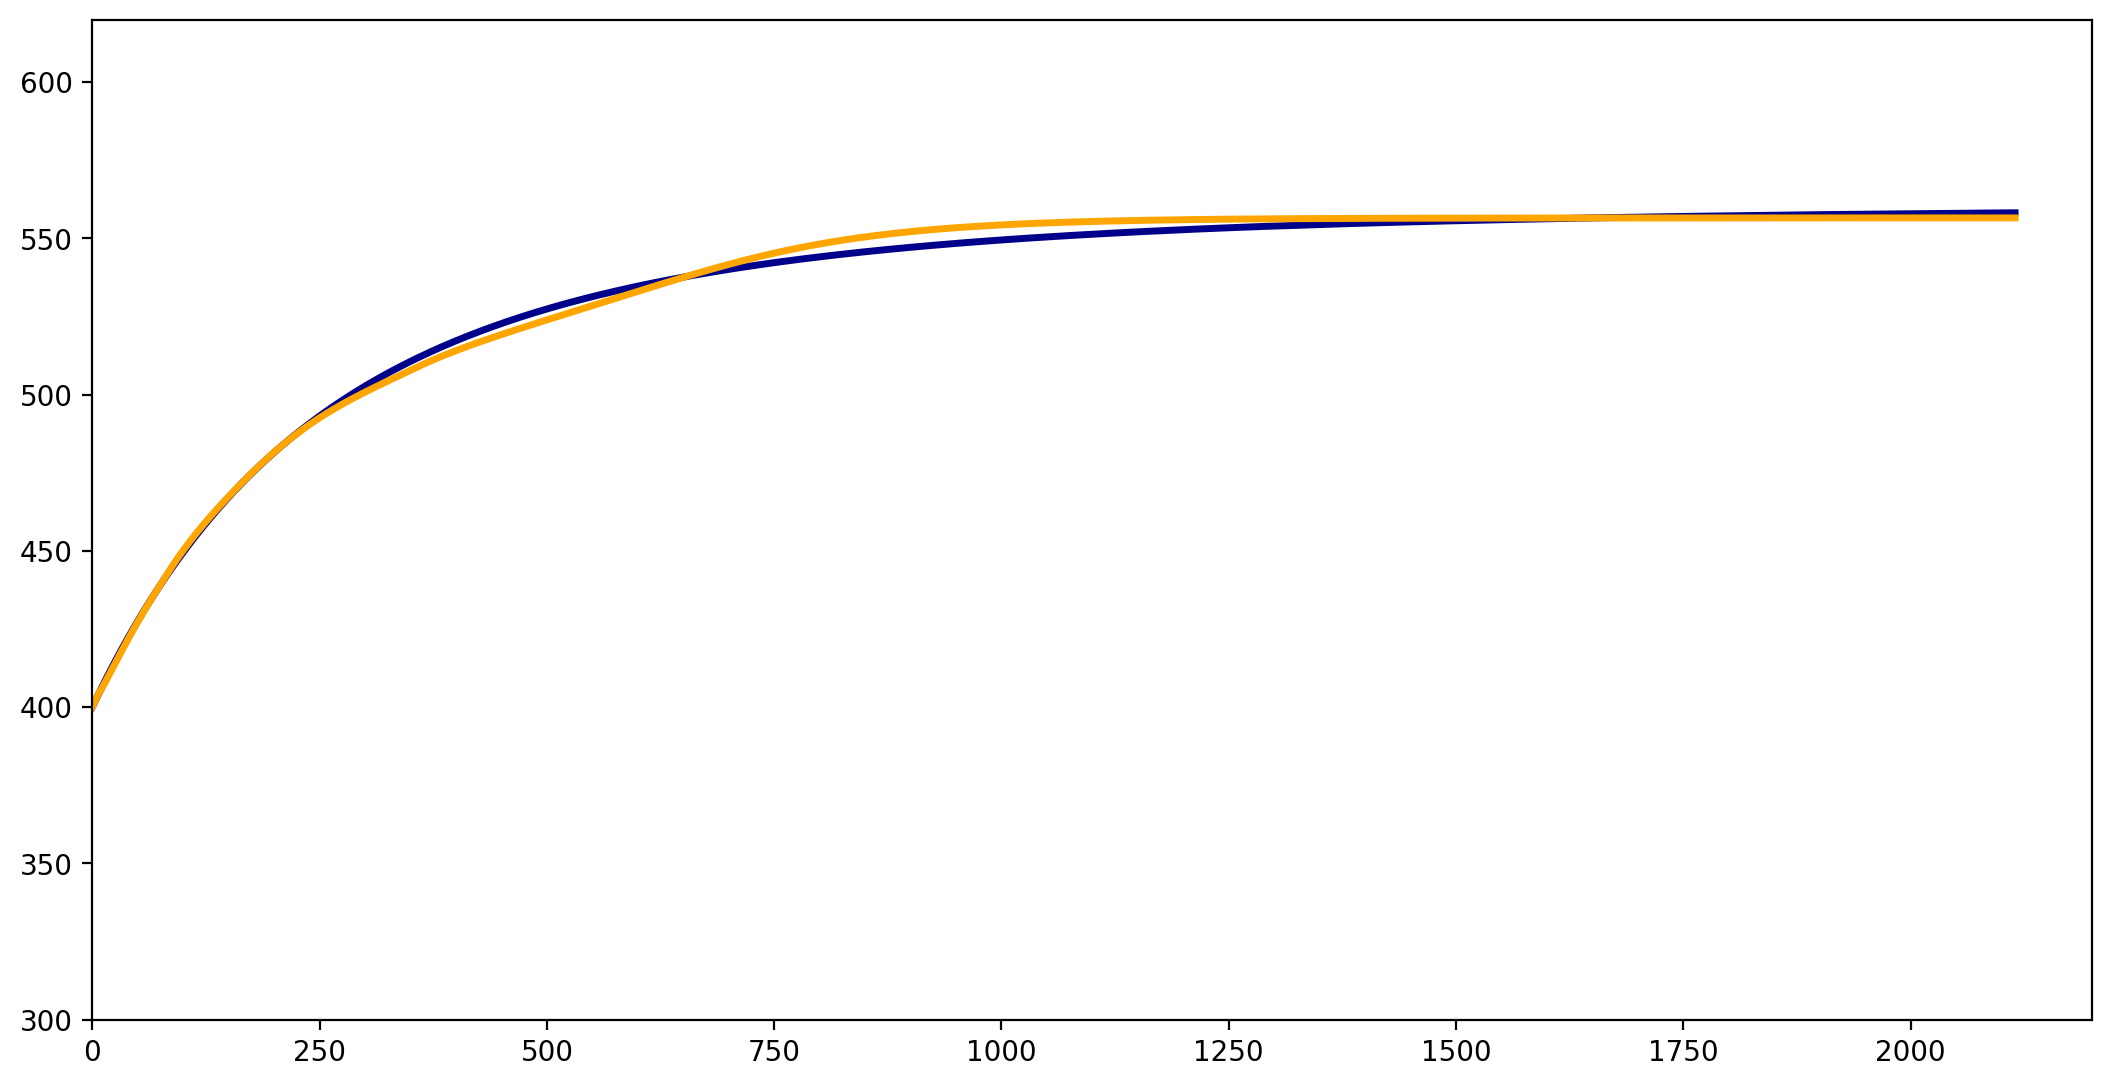

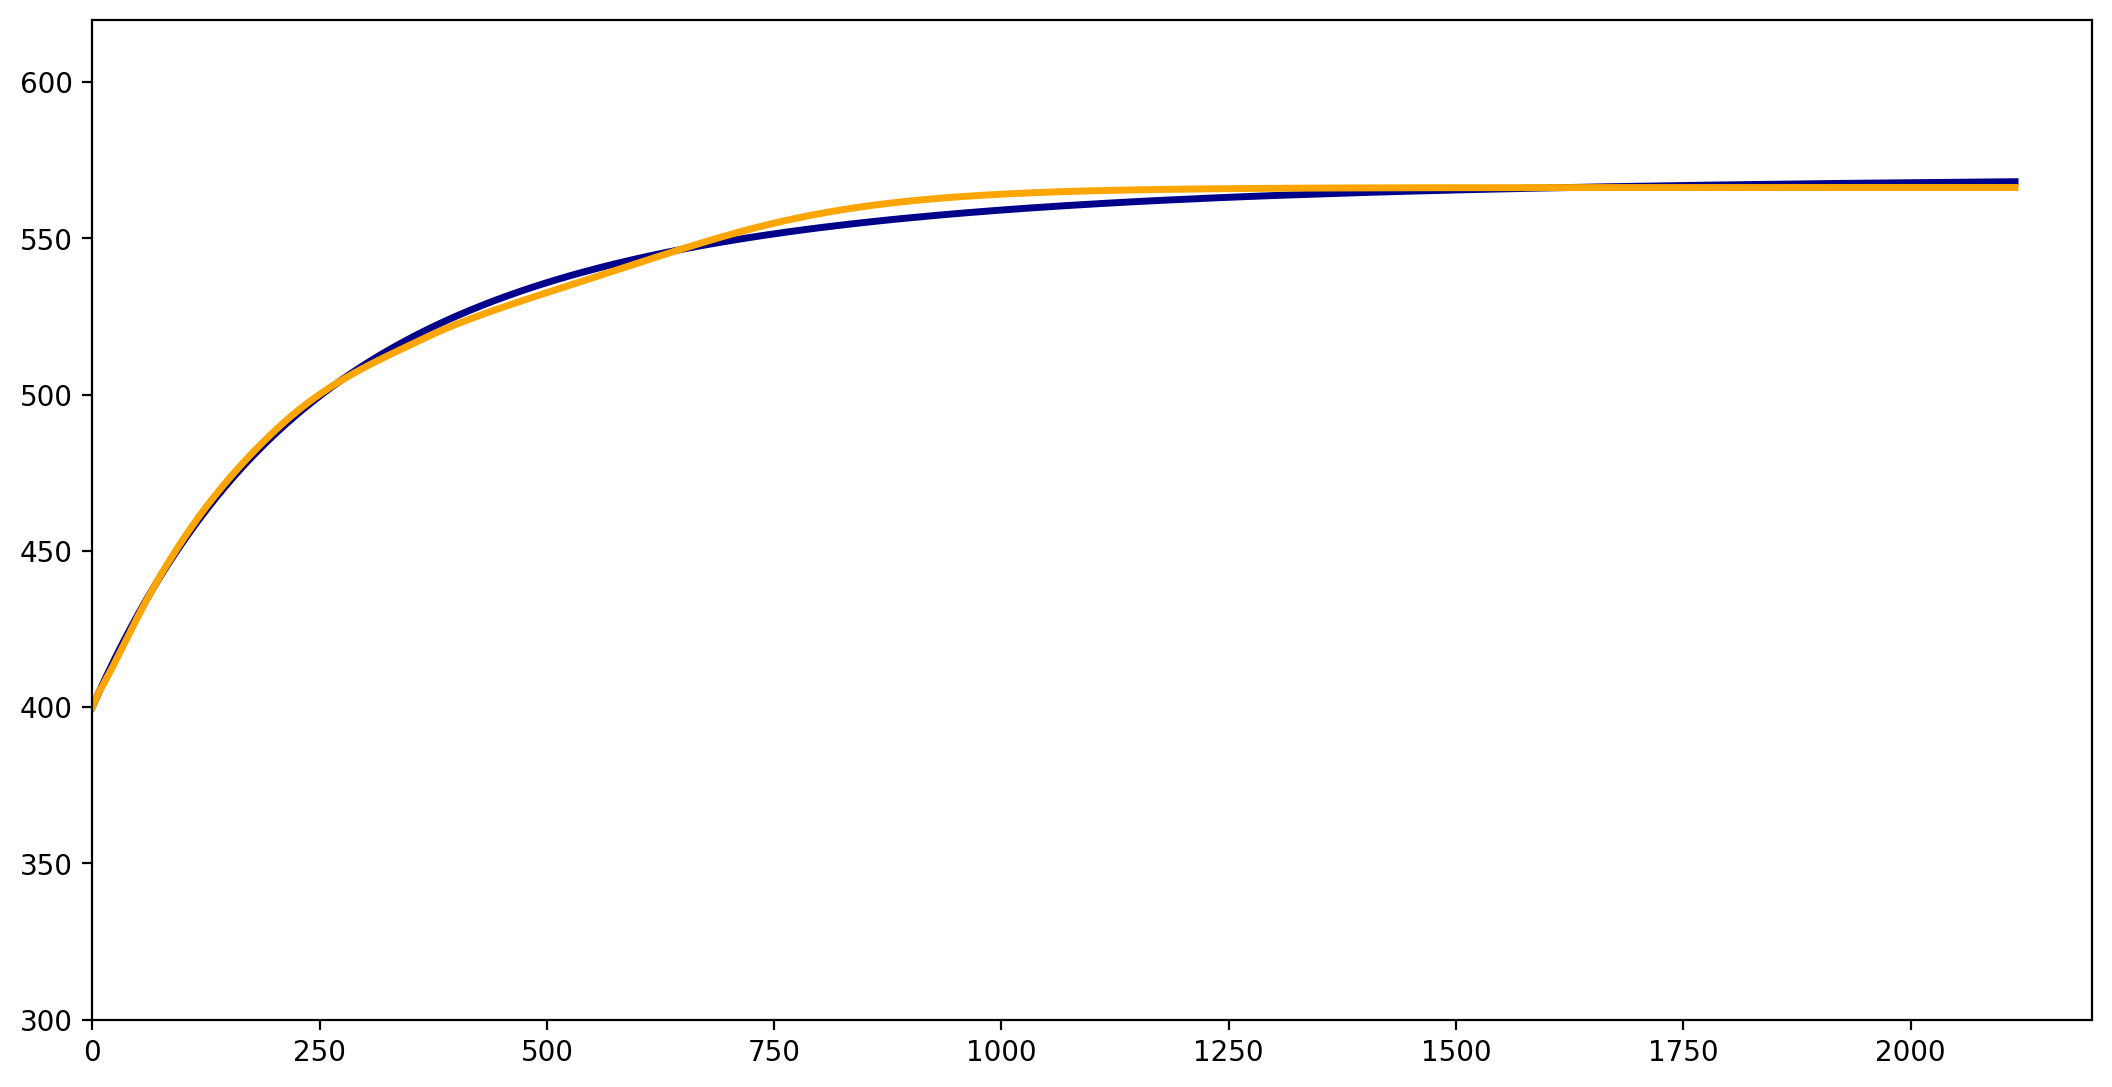

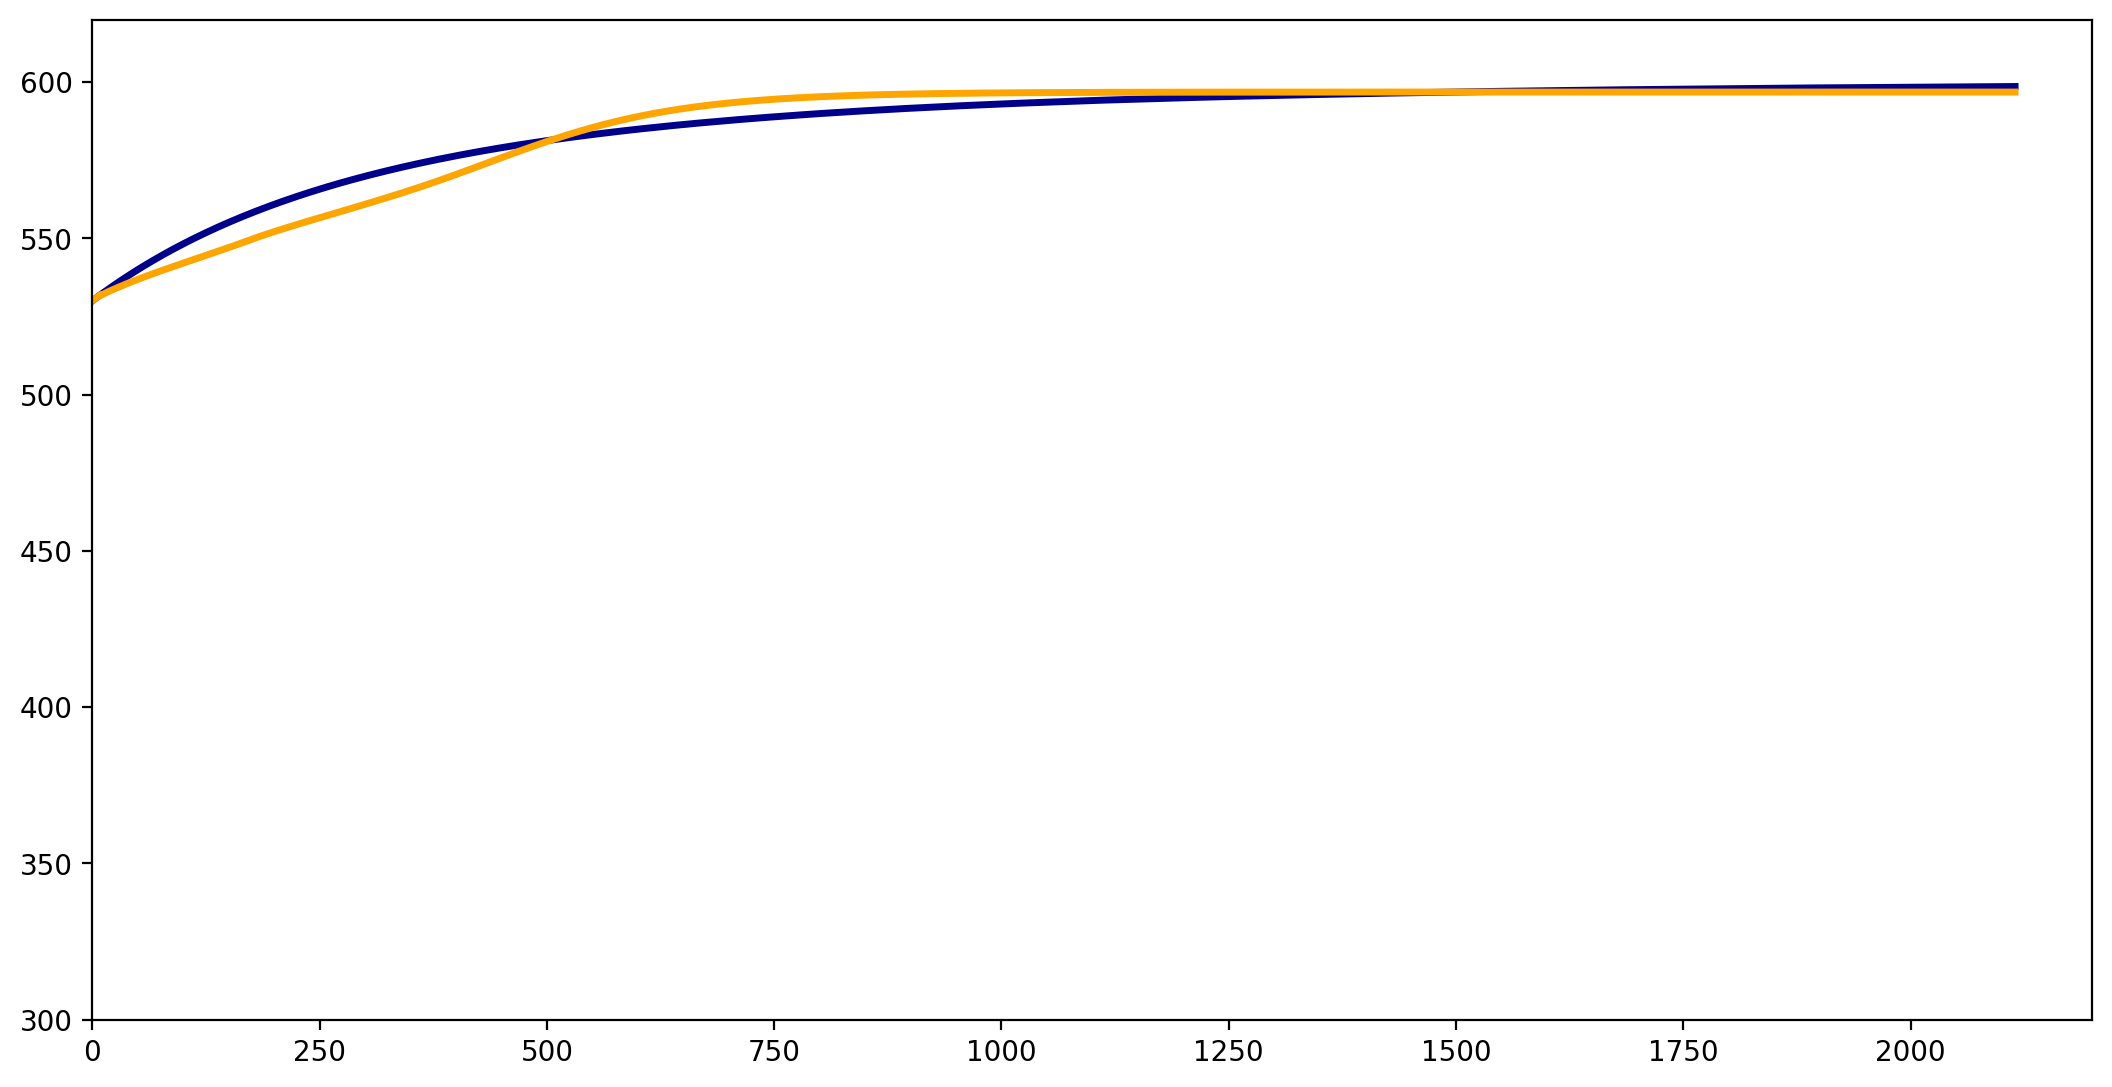

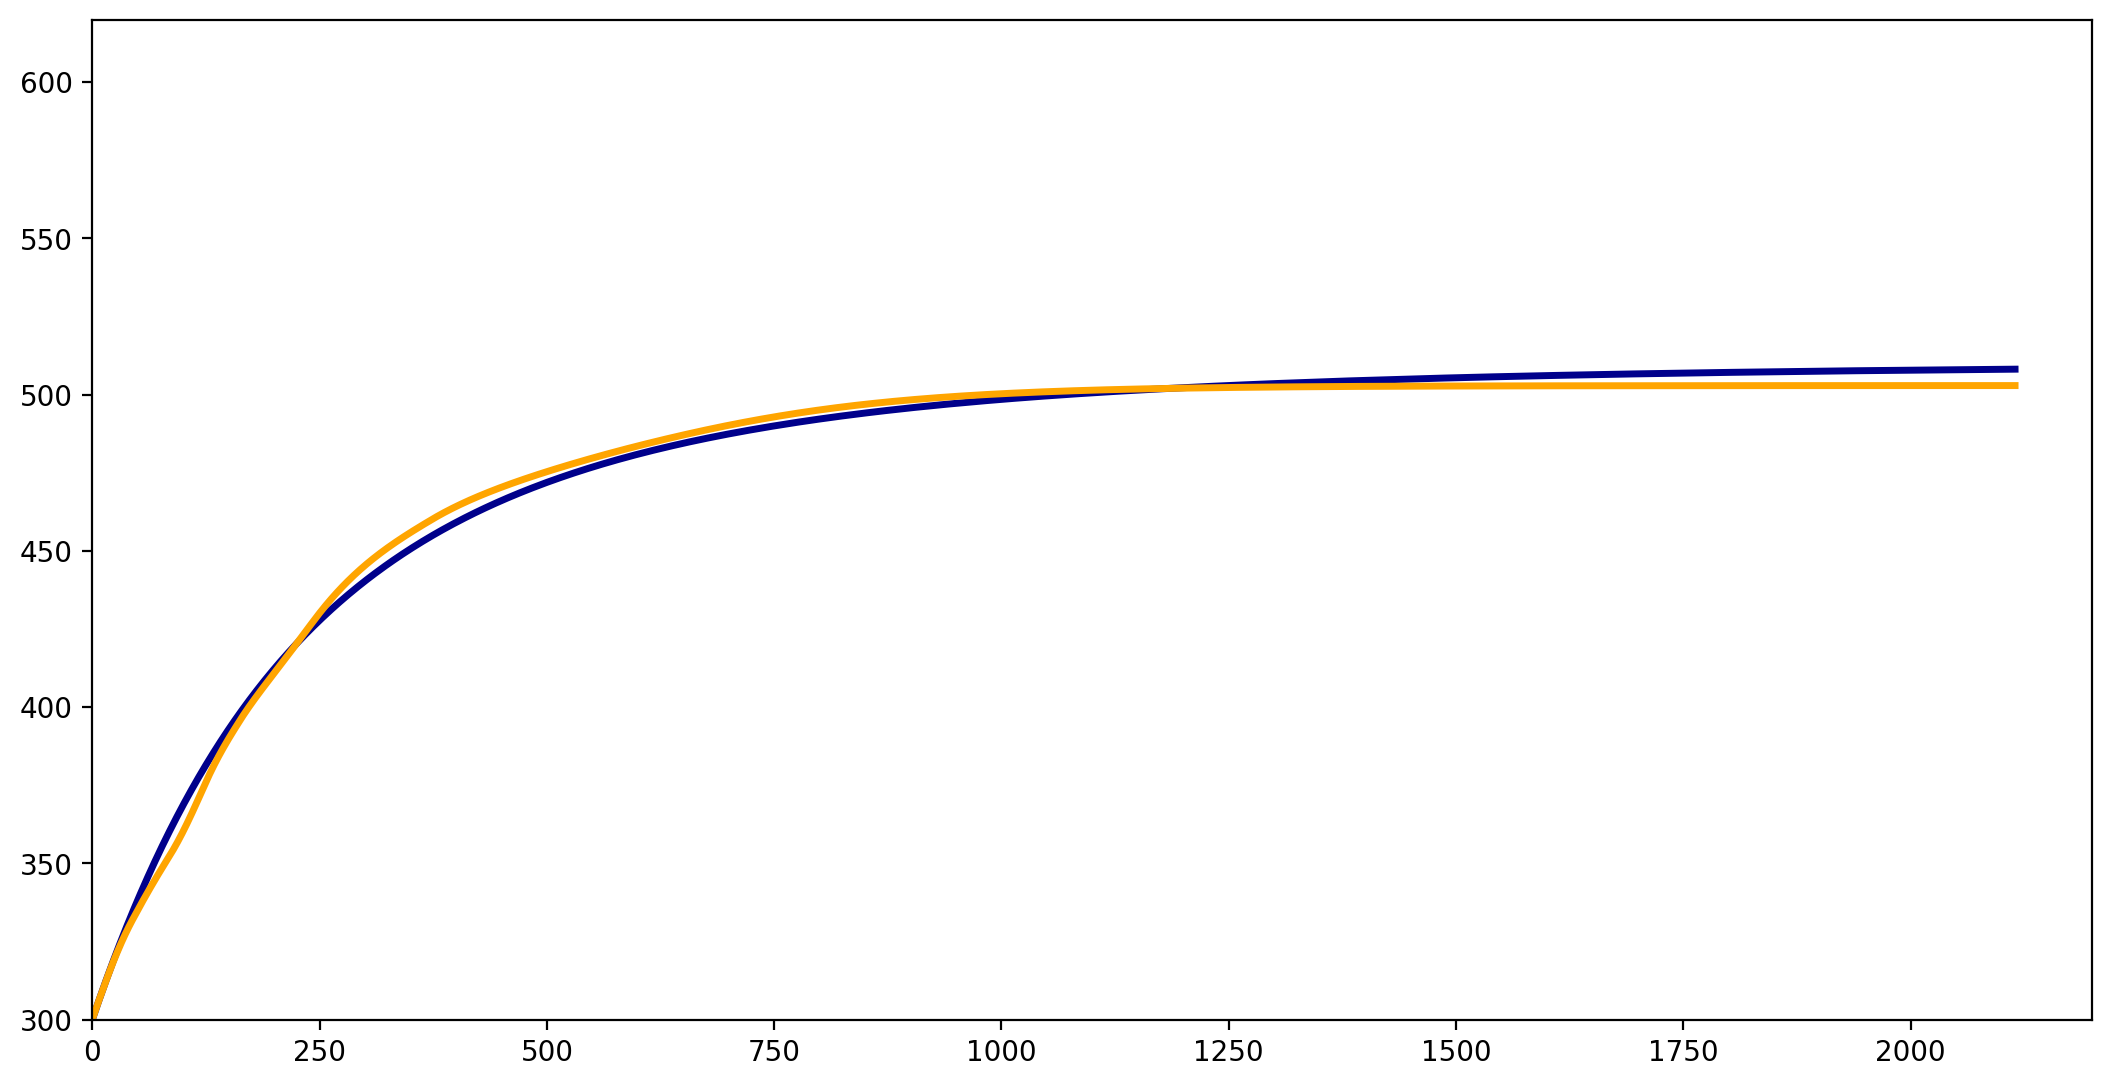

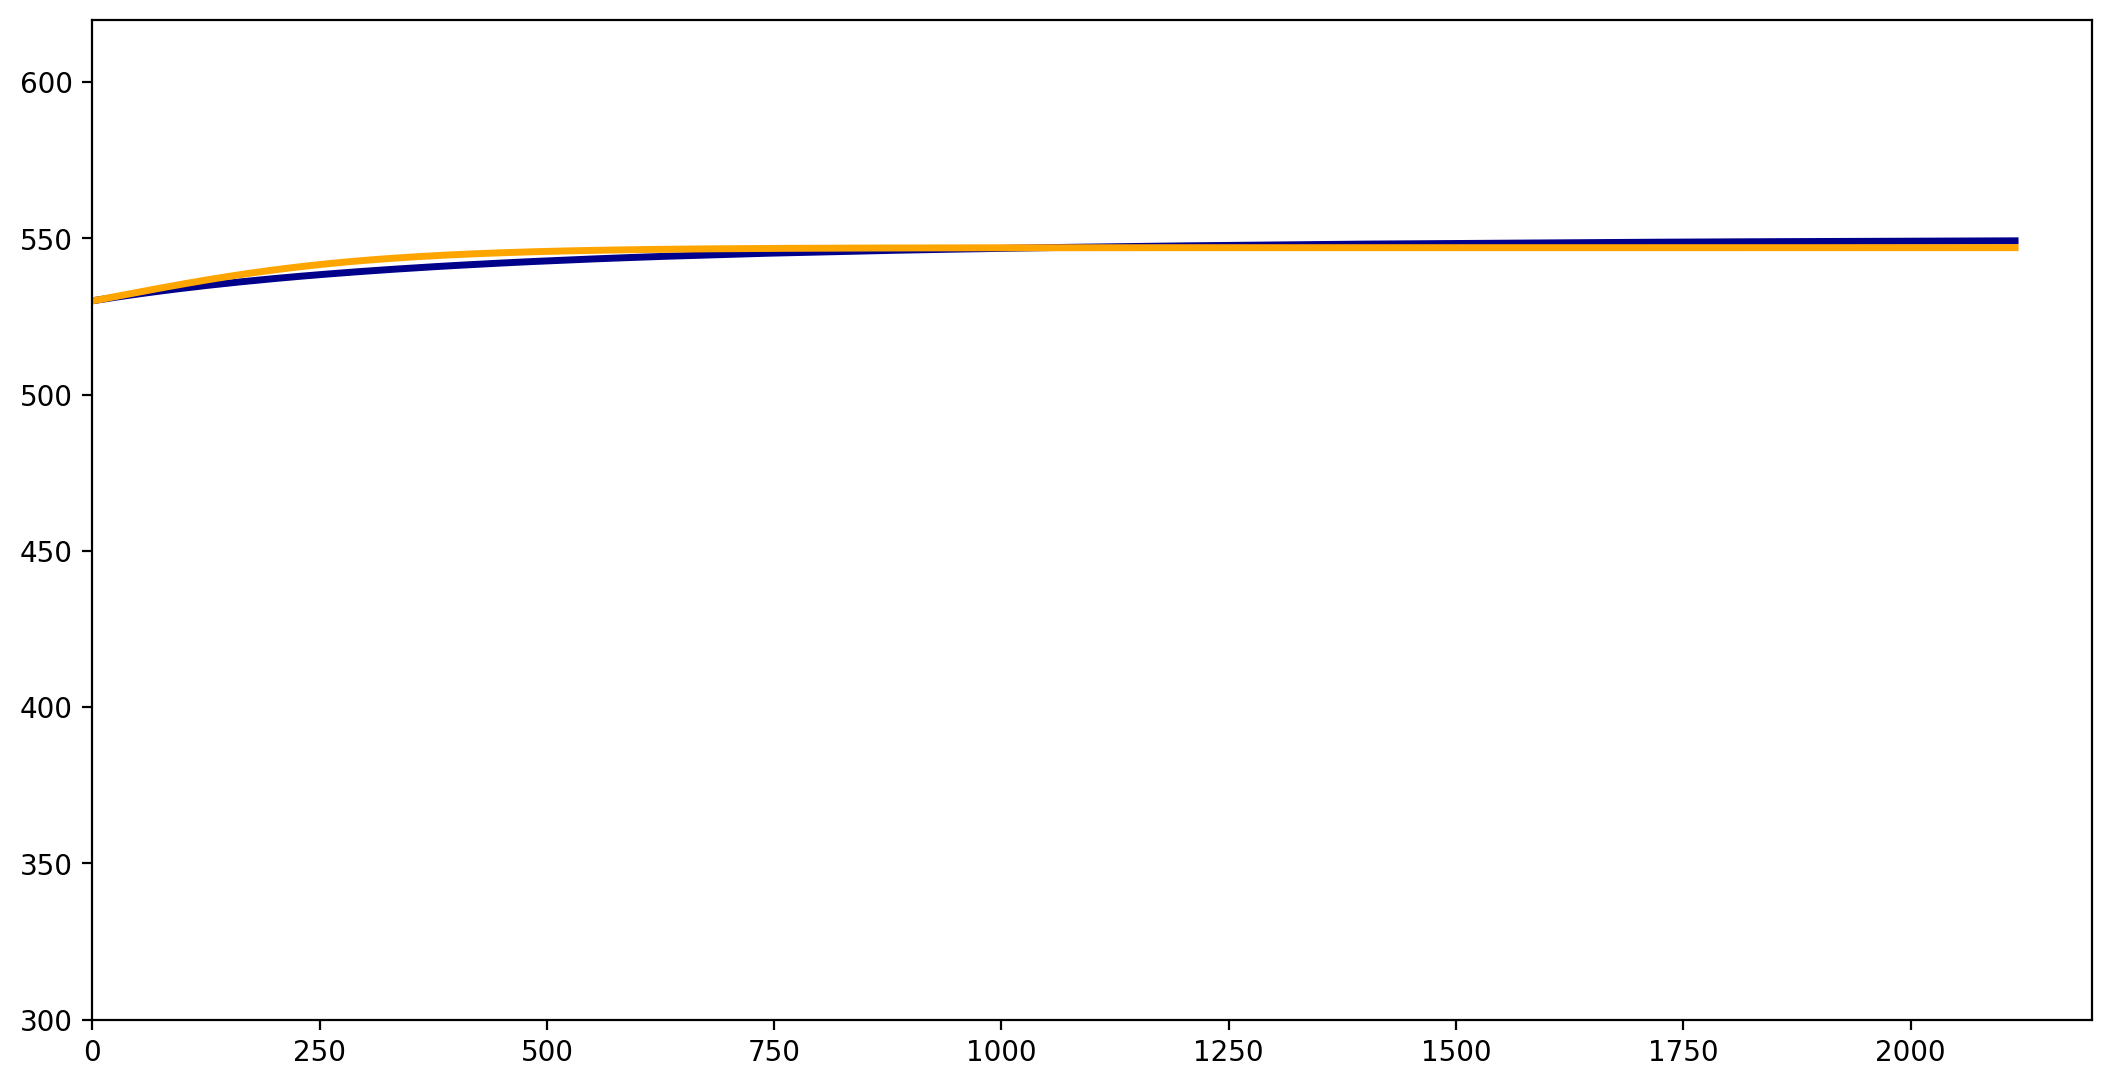

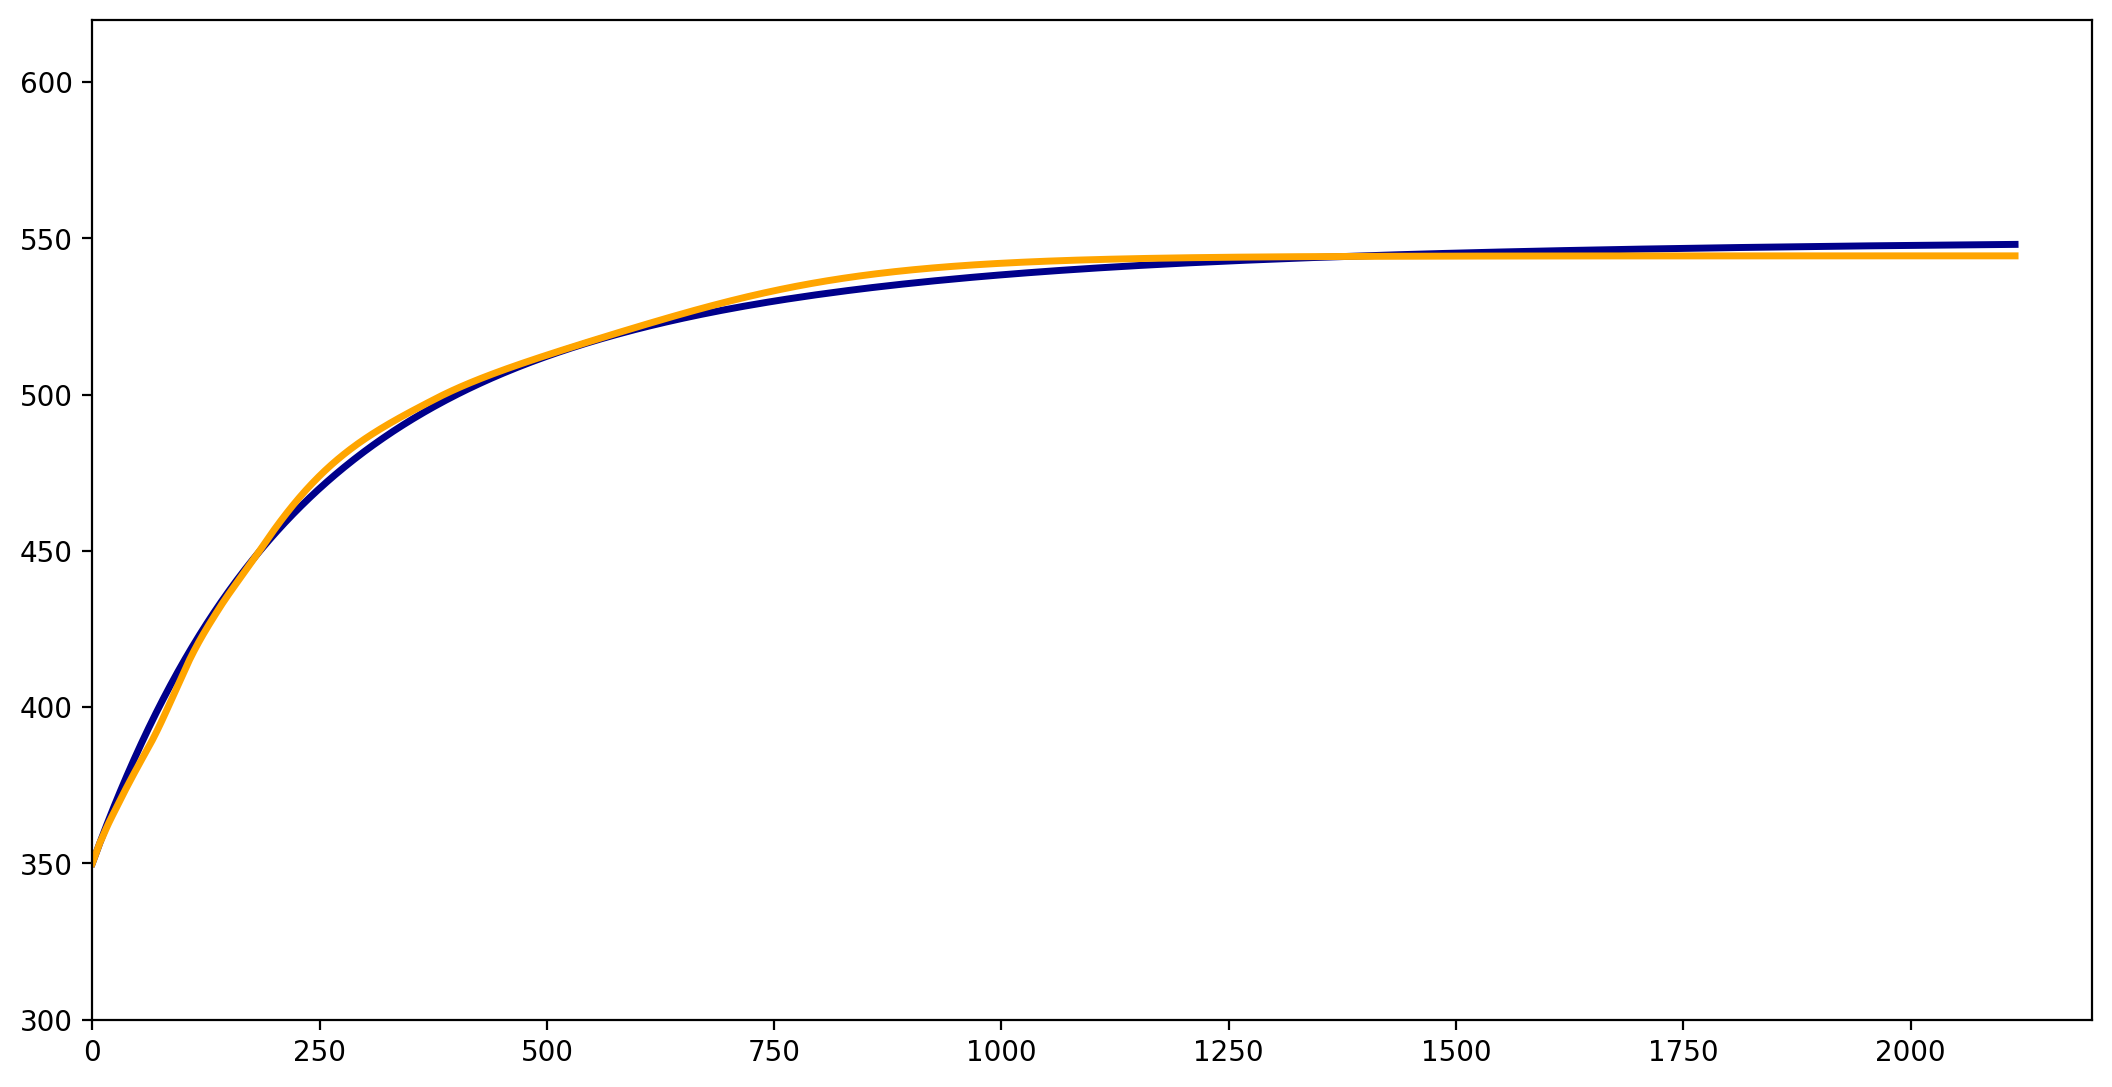

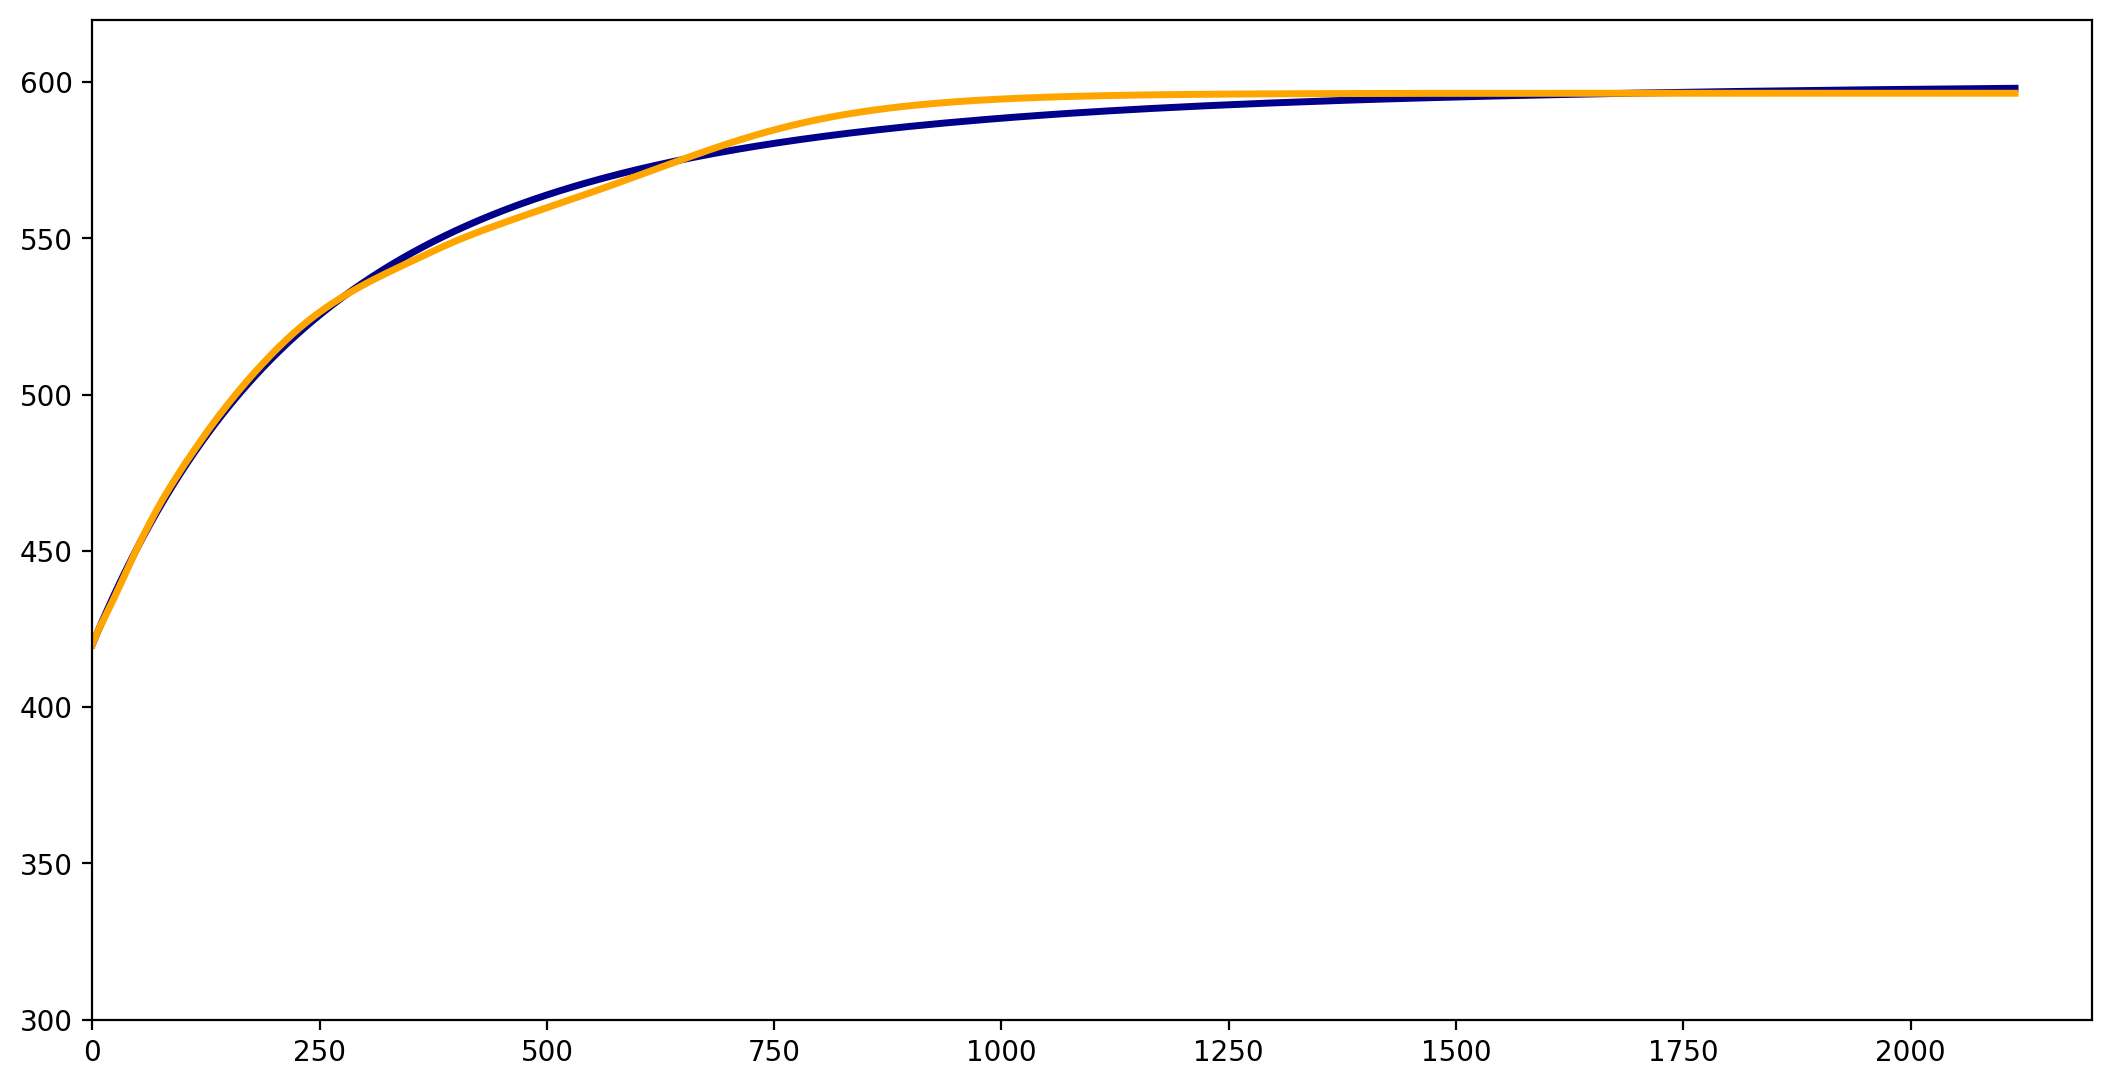

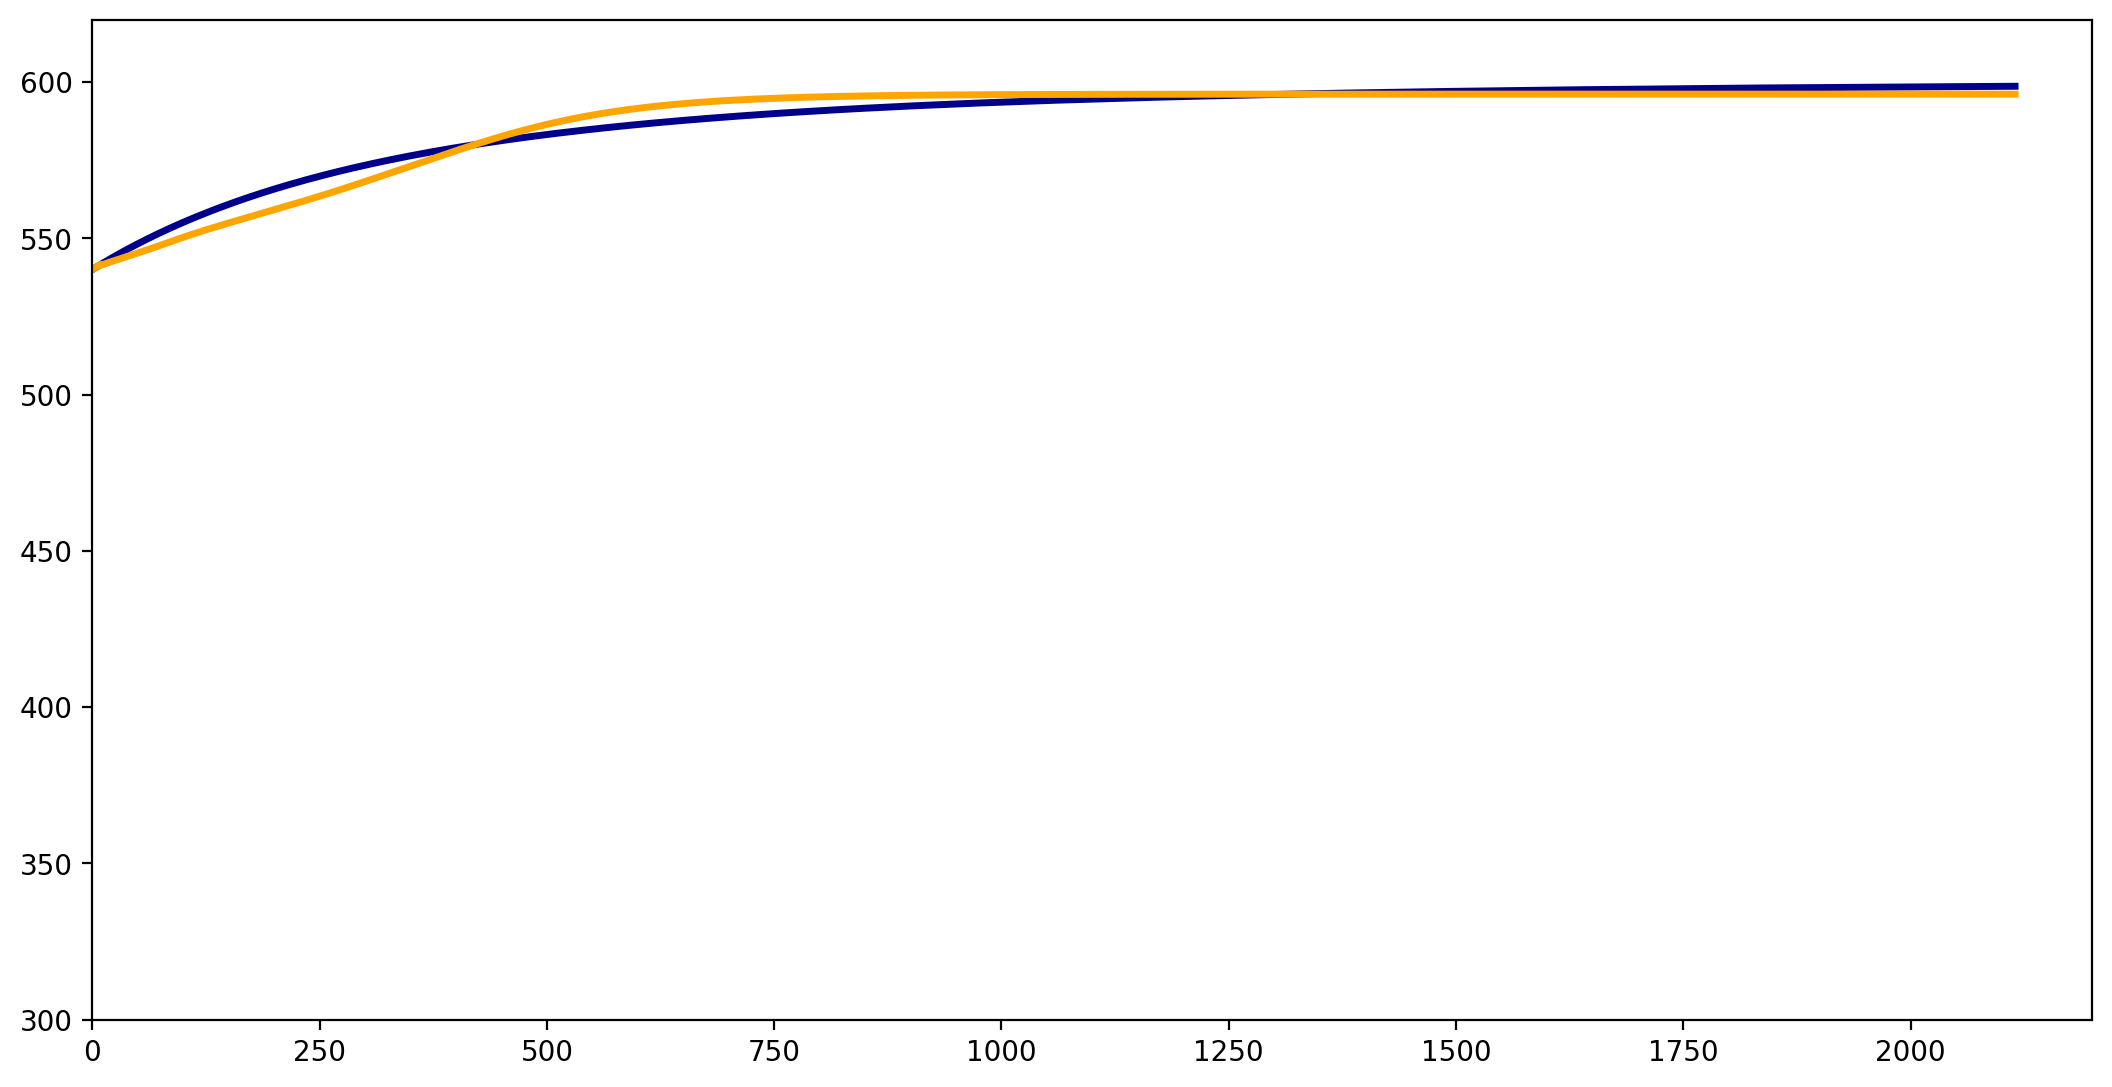

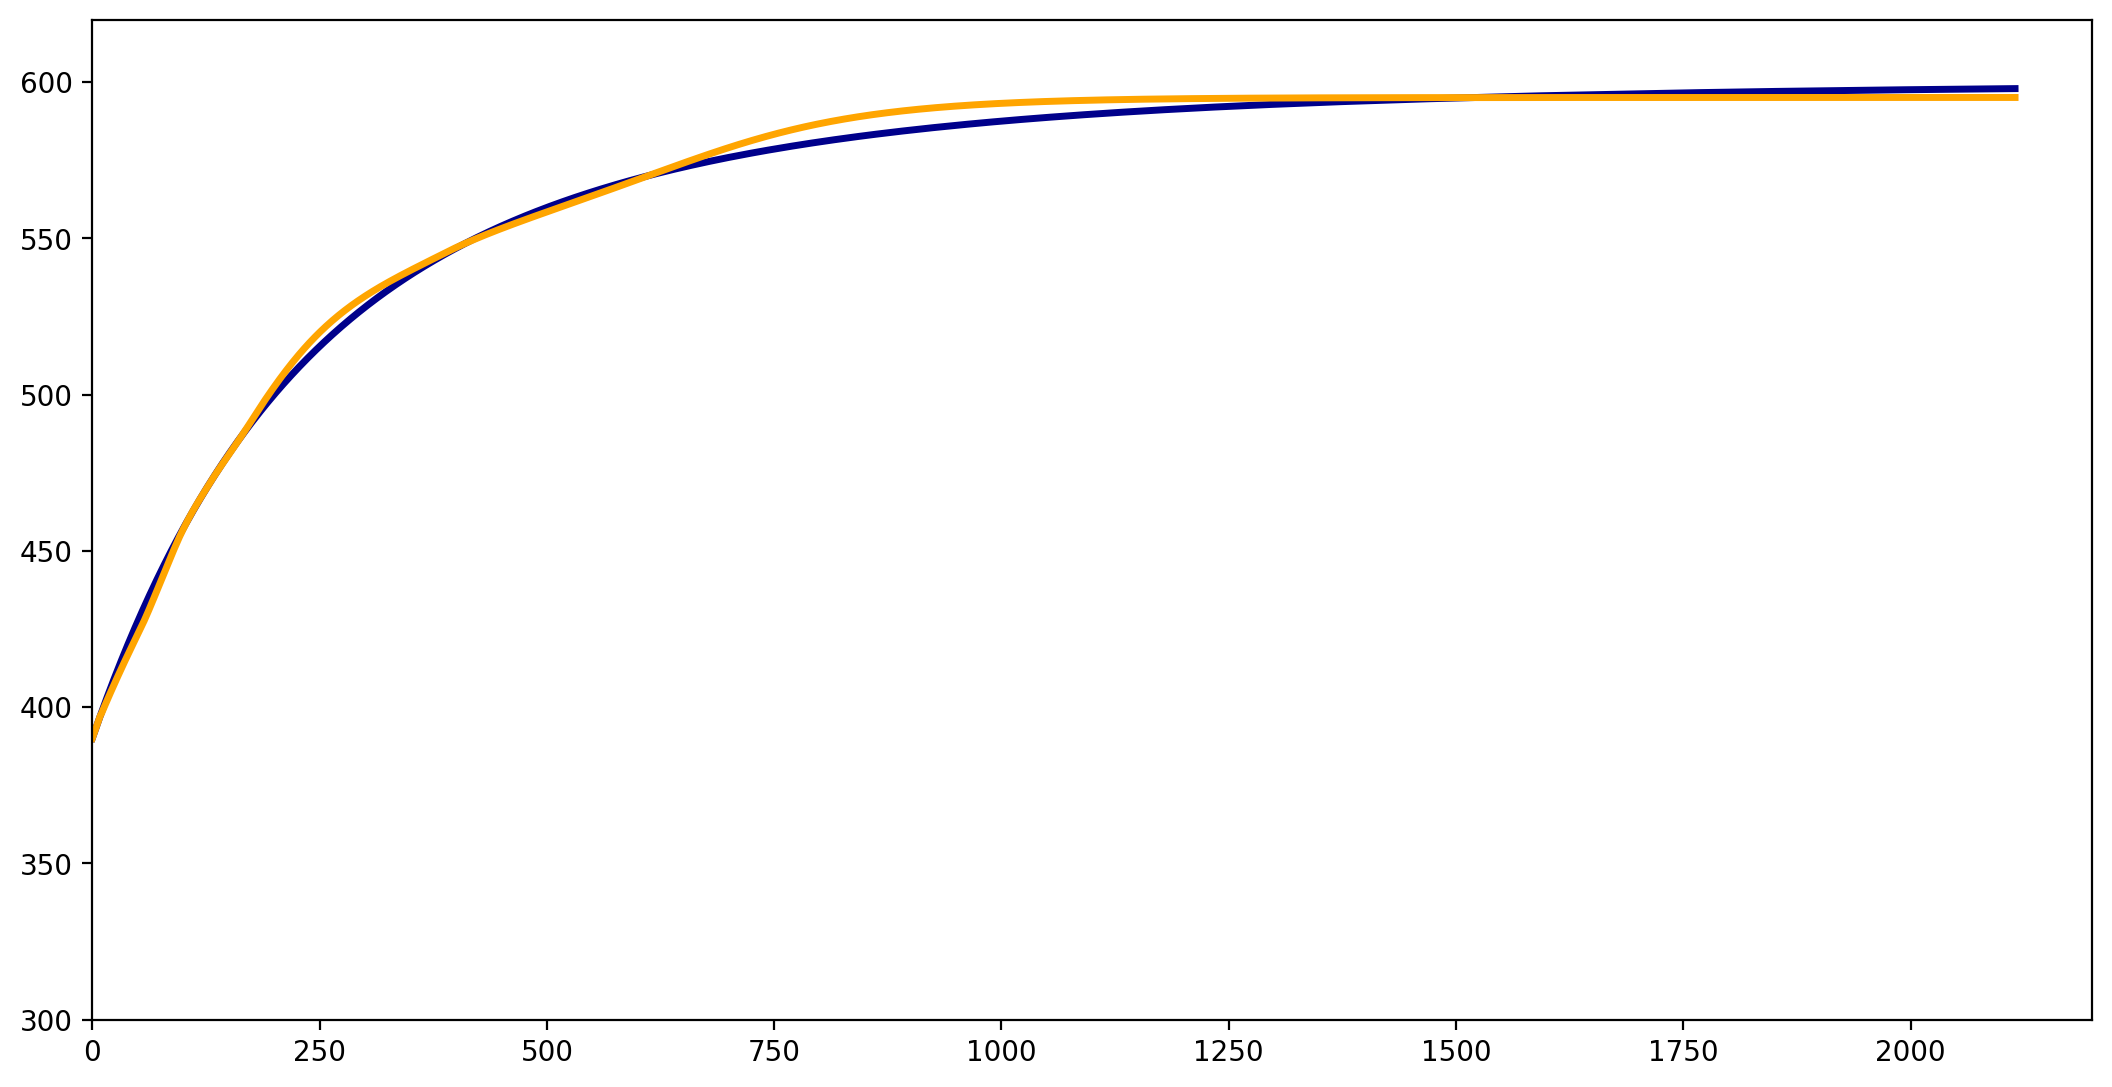

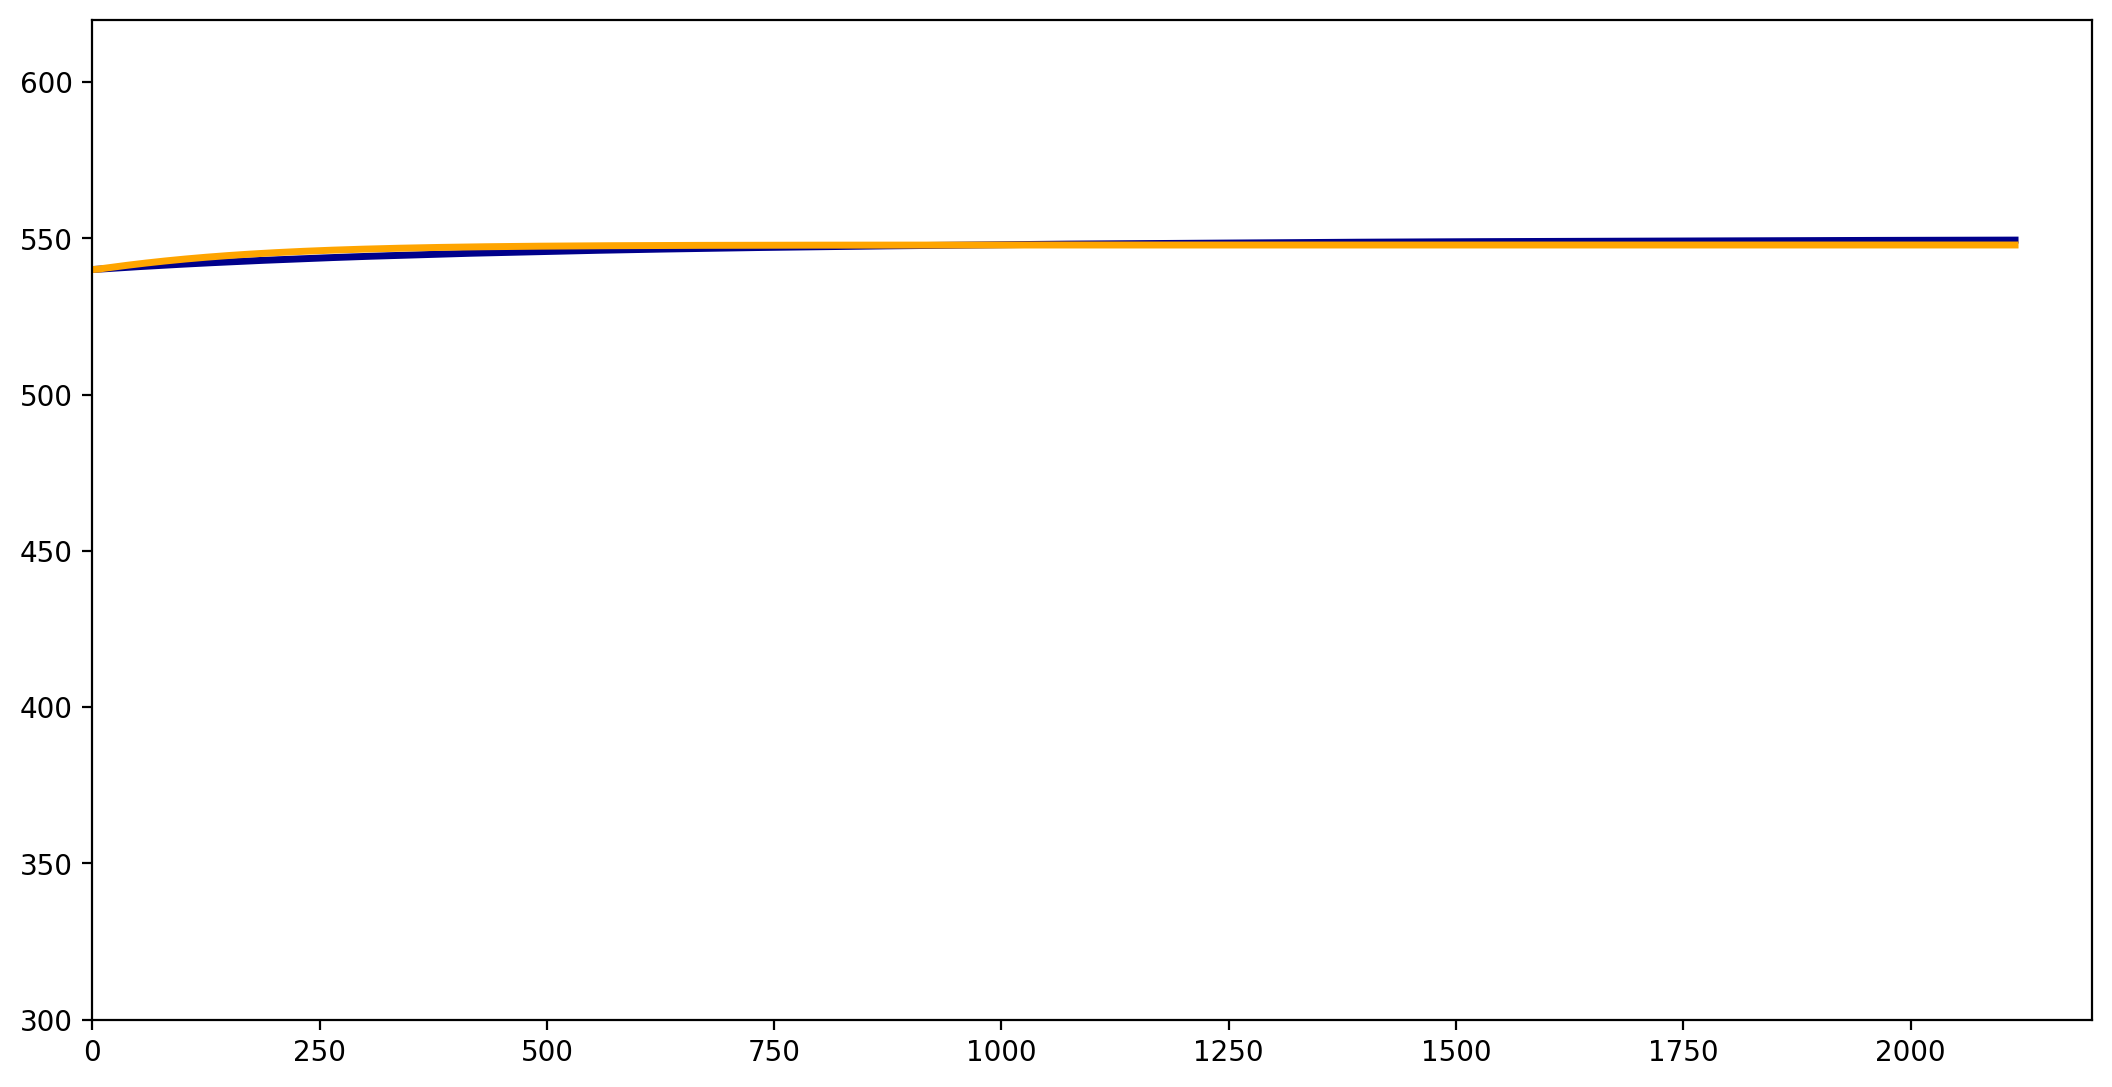

In [86]:
for i, y_sample in enumerate(y):
    ax = plt.figure(figsize=(10,5), dpi = 200).add_axes([0,0,1,1])
    ax.plot(y_sample, color='DarkBlue', linewidth=2.5, label="Expected")
    ax.plot(yhat[i], color='Orange', linewidth=2.5, label="Predicted")
    ax.set_ylim(300,620)
    ax.set_xlim(0,2200)
    plt.show()

In [87]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [88]:
y_tot = list()
for y_sample in y:
    for y_ts in y_sample:
        y_tot.append(y_ts)

In [89]:
yhat_tot = list()
for y_sample in yhat:
    for y_ts in y_sample:
        yhat_tot.append(y_ts)

In [90]:
print(r2_score(y_tot, yhat_tot))

0.9879211225697893


In [91]:
print(mean_squared_error(y_tot, yhat_tot, squared=False))

8.07936560832011
